In [ ]:
# QSAR Challenge - 2024 - AI in Life Science

# Preparation of Environment and loading Data


In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 20.9 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.6 MB/s eta 0:00:00


In [ ]:
# Basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Chemistry
import rdkit
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger


RDLogger.DisableLog('rdApp.*')
print(rdkit.__version__)

# ID generators
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import MACCSkeys

from tqdm import tqdm

# ML moduls
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow_addons as tfa



2023.09.5


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# train_data
data_train = pd.read_csv("/content/data_train.csv")

In [ ]:
# data to predict
smiles_test = pd.read_csv("/content/smiles_test.csv")

In [ ]:
# Rename Unnamed: 0 --> ID
data_train.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
smiles_test.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

In [ ]:
# Filter columns containing "task" in the name to have y for training and eval
task_cols = [col for col in data_train.columns if "task" in col]
y = data_train[task_cols]
y

task1  task2  task3  task4  task5  task6  task7  task8  task9  task10  \
0          0      0      0      0      0      0      0     -1     -1       0   
1          0      0      0      0      0     -1      0      0      0       0   
2          0      0      1      0      0      0      0      0      0       0   
3          0      0      0      0      1      0      0      0     -1       0   
4          0      0      0      0     -1      0      0     -1      1       0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
11995      0     -1      0      0      0     -1      0     -1     -1       0   
11996      0      0      0      0      0      0      0     -1     -1       0   
11997      0      0      1      0      0      0      0      0      0       0   
11998      0      0      0      0      0      0      1      0     -1       0   
11999      0      0      0      0      0      0      0     -1     -1       0   

       task11  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
11995       0  
11996       0  
11997       0  
11998       0  
11999       0  

[12000 rows x 11 columns]

# SMILES to mol

Convert SMILES to rdkit mols: 100%|██████████| 12000/12000 [00:02<00:00, 4259.11it/s]


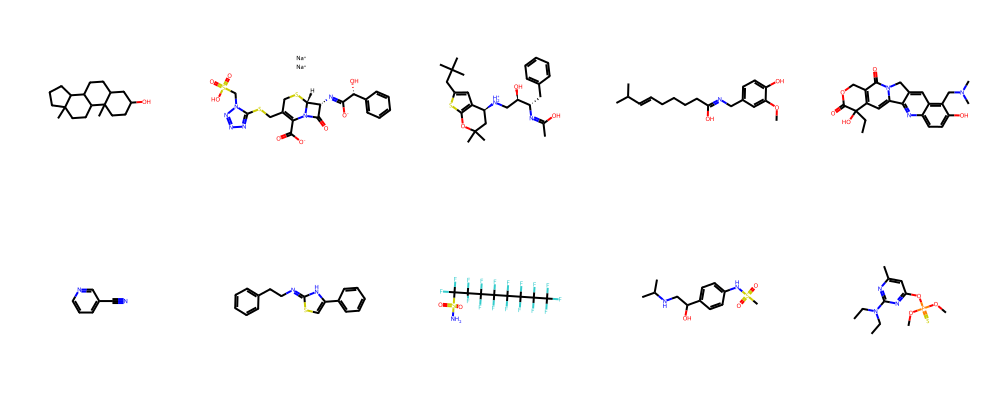

In [ ]:
# Convert SMILES to mols <--DATA_TRAIN
data_train['mol'] = [Chem.MolFromSmiles(smi) for smi in tqdm(data_train['smiles'], desc='Convert SMILES to rdkit mols')]
Draw.MolsToGridImage(data_train['mol'][:10], molsPerRow=5)

Convert SMILES to rdkit mols: 100%|██████████| 5896/5896 [00:01<00:00, 3166.40it/s]


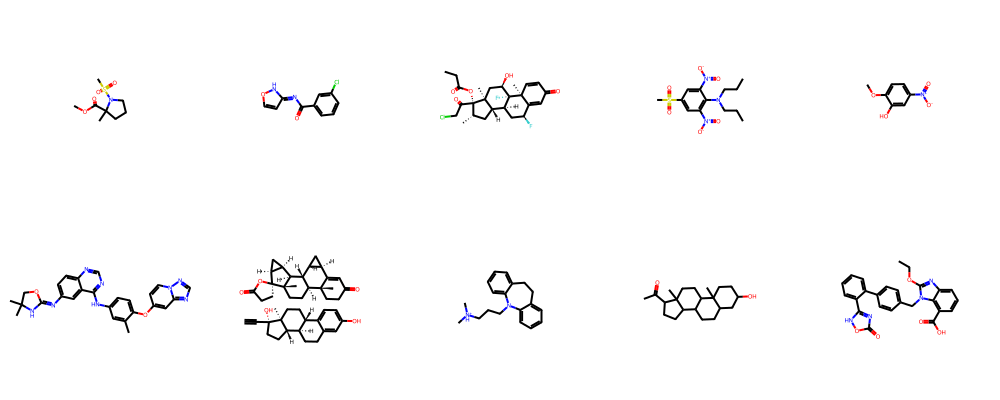

In [ ]:
# Convert SMILES to mols <--SMILES_TEST
smiles_test['mol'] = [Chem.MolFromSmiles(smi) for smi in tqdm(smiles_test['smiles'], desc='Convert SMILES to rdkit mols')]
Draw.MolsToGridImage(smiles_test['mol'][:10], molsPerRow=5)

# Fingerprint generator

In [ ]:
# Initialize fp generator
mfpgen = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)

In [ ]:
# Compute fingerprints<--Smiles
smiles_test_mfp = np.array([mfpgen.GetFingerprintAsNumPy(mol) for mol in tqdm(smiles_test.mol, desc='Compute Morgan fingerprints')])

Compute Morgan fingerprints: 100%|██████████| 5896/5896 [00:01<00:00, 5635.01it/s]


In [ ]:
# Compute fingerprints<--Training
data_train_mfp = np.array([mfpgen.GetFingerprintAsNumPy(mol) for mol in tqdm(data_train.mol, desc='Compute Morgan fingerprints')])

Compute Morgan fingerprints: 100%|██████████| 12000/12000 [00:01<00:00, 8003.01it/s]


In [ ]:
data_train_mfp = pd.DataFrame(data_train_mfp)
data_train_mfp

0     1     2     3     4     5     6     7     8     9     ...  1014  \
0         0     0     0     0     1     0     0     0     0     0  ...     0   
1         0     1     0     0     0     1     0     0     0     0  ...     1   
2         0     1     0     1     0     0     0     0     0     0  ...     0   
3         0     1     0     1     0     0     0     0     0     0  ...     0   
4         0     0     0     0     0     0     0     0     0     0  ...     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
11995     0     0     0     0     0     0     1     0     0     0  ...     0   
11996     0     0     0     0     0     0     0     0     0     0  ...     0   
11997     0     1     0     0     0     0     0     0     0     0  ...     0   
11998     0     0     0     0     0     0     0     0     0     0  ...     0   
11999     0     1     0     0     0     0     0     0     0     0  ...     0   

       1015  1016  1017  1018  1019  1020  1021  1022  1023  
0         0     0     0     0     1     0     0     0     0  
1         0     0     0     0     1     0     0     0     0  
2         0     0     1     0     1     0     0     0     0  
3         0     0     0     0     0     0     0     0     0  
4         0     0     0     0     0     0     0     0     0  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
11995     0     0     0     0     0     0     0     0     0  
11996     0     0     0     0     1     0     0     0     0  
11997     0     0     0     0     0     0     0     0     0  
11998     0     0     0     0     0     0     0     0     0  
11999     0     0     0     0     0     0     0     0     0  

[12000 rows x 1024 columns]

In [ ]:
smiles_test_mfp = pd.DataFrame(smiles_test_mfp)
smiles_test_mfp

0     1     2     3     4     5     6     7     8     9     ...  1014  \
0        0     0     0     0     1     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
5891     0     0     0     0     0     0     0     0     0     0  ...     0   
5892     0     0     0     0     0     0     0     0     0     0  ...     0   
5893     0     0     0     0     0     1     0     0     0     0  ...     0   
5894     0     0     0     0     0     0     0     0     0     0  ...     0   
5895     0     0     0     0     0     0     0     0     0     0  ...     0   

      1015  1016  1017  1018  1019  1020  1021  1022  1023  
0        0     0     0     0     0     0     0     0     0  
1        0     0     0     0     0     0     0     0     0  
2        0     0     0     0     1     0     0     0     0  
3        0     0     0     0     0     0     0     0     0  
4        0     0     0     0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
5891     0     0     0     0     0     0     0     0     0  
5892     0     0     0     0     1     0     0     0     0  
5893     0     0     0     0     1     0     0     0     0  
5894     0     0     0     0     0     0     0     0     0  
5895     0     0     0     0     0     0     0     0     0  

[5896 rows x 1024 columns]

# MACCSKeys

In [ ]:
# FUNCTION to extract SMILES to MACCSKeys and keep IDs and index in the dataframe
def get_maccs_keys(df):
    fps = np.array([MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles)) for smiles in df['smiles']])
    ids = df['ID'].values
    maccs_df = pd.DataFrame(fps, index=ids)
    return maccs_df

In [ ]:
# smiles_test is your dataset
data_train_maccsk = get_maccs_keys(data_train)

In [ ]:
# smiles_test is your dataset
smiles_test_maccsk = get_maccs_keys(smiles_test)

In [ ]:
smiles_test_maccsk

0    1    2    3    4    5    6    7    8    9    ...  157  158  159  \
0       0    0    0    0    0    0    0    0    0    0  ...    1    1    1   
1       0    0    0    0    0    0    0    0    0    0  ...    0    1    1   
2       0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
3       0    0    0    0    0    0    0    0    0    0  ...    0    1    1   
4       0    0    0    0    0    0    0    0    0    0  ...    1    1    1   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5891    0    0    0    0    0    0    0    0    0    0  ...    0    1    1   
5892    0    0    0    0    0    0    0    0    0    0  ...    1    1    0   
5893    0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
5894    0    0    0    0    0    0    0    0    0    0  ...    0    1    1   
5895    0    0    0    0    0    0    0    0    0    0  ...    1    1    1   

      160  161  162  163  164  165  166  
0       1    1    0    0    1    1    0  
1       0    1    1    1    1    1    0  
2       1    0    0    1    1    1    0  
3       1    1    1    1    1    1    0  
4       1    1    1    1    1    1    0  
...   ...  ...  ...  ...  ...  ...  ...  
5891    1    1    1    1    1    1    0  
5892    1    1    1    1    1    1    0  
5893    0    0    1    1    1    1    0  
5894    1    1    1    1    1    1    0  
5895    0    1    1    1    1    1    0  

[5896 rows x 167 columns]

# RDKit Description function

In [ ]:
# Define description list --> 210 in total

description_list = Chem.Descriptors._descList
print("Number of descriptor list :", len(description_list)) #210 in total

print(description_list)

Number of descriptor list : 210
[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x7af9794df490>), ('MaxEStateIndex', <function MaxEStateIndex at 0x7af9794df370>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x7af9794df520>), ('MinEStateIndex', <function MinEStateIndex at 0x7af9794df400>), ('qed', <function qed at 0x7af9768de320>), ('SPS', <function SPS at 0x7af9768de7a0>), ('MolWt', <function <lambda> at 0x7af9768dedd0>), ('HeavyAtomMolWt', <function HeavyAtomMolWt at 0x7af9768dee60>), ('ExactMolWt', <function <lambda> at 0x7af9768deef0>), ('NumValenceElectrons', <function NumValenceElectrons at 0x7af9768def80>), ('NumRadicalElectrons', <function NumRadicalElectrons at 0x7af9768df010>), ('MaxPartialCharge', <function MaxPartialCharge at 0x7af9768df130>), ('MinPartialCharge', <function MinPartialCharge at 0x7af9768df1c0>), ('MaxAbsPartialCharge', <function MaxAbsPartialCharge at 0x7af9768df250>), ('MinAbsPartialCharge', <function MinAbsPartialCharge at 0x7af9768df2e0>), (

In [ ]:
# FUNCTION
def generate_descriptors(smiles_test):
    description_list = [x[0] for x in Chem.Descriptors._descList]
    descriptors = {}

    for index, row in smiles_test.iterrows():
        mol = Chem.MolFromSmiles(row['smiles'])
        descriptors[row['ID']] = [desc[1](mol) for desc in Chem.Descriptors._descList]

    df_descriptors = pd.DataFrame.from_dict(descriptors, orient='index', columns=description_list)
    return df_descriptors

In [ ]:
data_train_desc = generate_descriptors(data_train) #runs for 2.5min

In [ ]:
smiles_test_desc = generate_descriptors(smiles_test) # runs for 1.5 min

In [ ]:
data_train_desc

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0              10.049826       10.049826           0.004594        0.004594   
1              12.716713       12.716713           0.000000       -4.413099   
2              11.007848       11.007848           0.003818       -0.667227   
3               9.787690        9.787690           0.105467        0.105467   
4              13.230323       13.230323           0.104072       -1.840670   
...                  ...             ...                ...             ...   
11995          11.078468       11.078468           0.120317       -0.682613   
11996          15.173143       15.173143           0.023953       -4.642797   
11997          14.026601       14.026601           0.041004       -1.093185   
11998           6.376748        6.376748           0.486523        0.486523   
11999           9.377409        9.377409           0.499117       -0.499117   

            qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  \
0      0.674808  58.650000  276.464         244.208  276.245316   
1      0.069823  20.324324  586.541         570.413  585.998713   
2      0.403040  20.343750  459.676         420.364  459.267591   
3      0.302480  12.272727  305.418         278.202  305.199094   
4      0.486542  19.322581  421.453         398.269  421.163771   
...         ...        ...      ...             ...         ...   
11995  0.590014  17.235294  242.235         228.123  242.101505   
11996  0.400308  21.930233  630.119         597.863  629.159864   
11997  0.154585  13.318182  608.710         568.390  608.304288   
11998  0.614635  13.318182  393.697         383.617  391.949807   
11999  0.606745  14.545455  156.269         136.109  156.151415   

       NumValenceElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                      114  ...           0             0           0   
1                      186  ...           2             0           0   
2                      176  ...           0             0           0   
3                      122  ...           0             0           0   
4                      160  ...           0             0           0   
...                    ...  ...         ...           ...         ...   
11995                   94  ...           0             0           0   
11996                  228  ...           0             1           0   
11997                  234  ...           0             0           0   
11998                  110  ...           0             0           0   
11999                   66  ...           0             0           0   

       fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0                      0             0            0            0   
1                      0             1            0            0   
2                      0             0            0            0   
3                      0             0            0            0   
4                      0             0            0            0   
...                  ...           ...          ...          ...   
11995                  0             0            0            0   
11996                  0             0            0            0   
11997                  0             0            0            0   
11998                  0             0            0            0   
11999                  0             0            0            0   

       fr_thiophene  fr_unbrch_alkane  fr_urea  
0                 0                 0        0  
1                 0                 0        0  
2                 1                 0        0  
3                 0                 2        0  
4                 0                 0        0  
...             ...               ...      ...  
11995             0                 0        0  
11996             0                 0        0  
11997             0                 0        0  
11998             1                 0        0  
11999             0 

# Scaling description categories and removing columns with only 0s

In [ ]:
# FUNCTION normalization of description dataset
def MinMax(df):
  scaler = MinMaxScaler()
  cols_to_normalize = df.columns
  df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
  return df

In [ ]:
data_train_desc = MinMax(data_train_desc)
smiles_test_desc = MinMax(smiles_test_desc)

In [ ]:
# FUNCTION to delet cols with only with 0 in it
def remove_zero_cols(df):
    cols_to_delete = df.columns[df.eq(0).all(axis=0)]
    print(len(cols_to_delete))
    df_cut = df.drop(cols_to_delete, axis=1)
    return df_cut

In [ ]:
data_train_desc_cut_norm = remove_zero_cols(data_train_desc)

4


In [ ]:
smiles_test_desc_cut_norm = smiles_test_desc[data_train_desc_cut_norm.columns]

In [ ]:
data_train_desc_cut_norm

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0               0.564108        0.564108           0.000524        0.830458   
1               0.713803        0.713803           0.000000        0.455103   
2               0.617882        0.617882           0.000436        0.773376   
3               0.549394        0.549394           0.012033        0.839029   
4               0.742632        0.742632           0.011874        0.673673   
...                  ...             ...                ...             ...   
11995           0.621846        0.621846           0.013727        0.772068   
11996           0.851685        0.851685           0.002733        0.435586   
11997           0.787328        0.787328           0.004678        0.737184   
11998           0.357934        0.357934           0.055508        0.871406   
11999           0.526364        0.526364           0.056945        0.787659   

            qed       SPS     MolWt  HeavyAtomMolWt  ExactMolWt  \
0      0.711866  0.724500  0.038214        0.035942    0.038199   
1      0.066694  0.251065  0.082177        0.085355    0.082148   
2      0.422046  0.251305  0.064190        0.062626    0.064167   
3      0.314805  0.151604  0.042319        0.041091    0.042307   
4      0.511094  0.238691  0.058771        0.059279    0.058760   
...         ...       ...       ...             ...         ...   
11995  0.621440  0.212907  0.033361        0.033505    0.033355   
11996  0.419132  0.270903  0.088356        0.089514    0.088272   
11997  0.157086  0.164519  0.085320        0.085049    0.085312   
11998  0.647696  0.164519  0.054835        0.057059    0.054616   
11999  0.639282  0.179679  0.021172        0.019567    0.021160   

       NumValenceElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                 0.042191  ...        0.00           0.0         0.0   
1                 0.068838  ...        0.25           0.0         0.0   
2                 0.065137  ...        0.00           0.0         0.0   
3                 0.045152  ...        0.00           0.0         0.0   
4                 0.059215  ...        0.00           0.0         0.0   
...                    ...  ...         ...           ...         ...   
11995             0.034789  ...        0.00           0.0         0.0   
11996             0.084382  ...        0.00           0.5         0.0   
11997             0.086603  ...        0.00           0.0         0.0   
11998             0.040711  ...        0.00           0.0         0.0   
11999             0.024426  ...        0.00           0.0         0.0   

       fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0                    0.0           0.0          0.0          0.0   
1                    0.0           0.5          0.0          0.0   
2                    0.0           0.0          0.0          0.0   
3                    0.0           0.0          0.0          0.0   
4                    0.0           0.0          0.0          0.0   
...                  ...           ...          ...          ...   
11995                0.0           0.0          0.0          0.0   
11996                0.0           0.0          0.0          0.0   
11997                0.0           0.0          0.0          0.0   
11998                0.0           0.0          0.0          0.0   
11999                0.0           0.0          0.0          0.0   

       fr_thiophene  fr_unbrch_alkane  fr_urea  
0               0.0          0.000000      0.0  
1               0.0          0.000000      0.0  
2               0.5          0.000000      0.0  
3               0.0          0.025641      0.0  
4               0.0          0.000000      0.0  
...             ...               ...      ...  
11995           0.0          0.000000      0.0  
11996           0.0          0.000000      0.0  
11997           0.0          0.000000      0.0  
11998           0.5          0.000000      0.0  
11999           0.0 

In [ ]:
smiles_test_desc_cut_norm

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0              0.652015        0.652015           0.039939        0.440103   
1              0.658425        0.658425           0.037127        0.623011   
2              0.977724        0.977724           0.004374        0.506689   
3              0.662918        0.662918           0.014471        0.410728   
4              0.580460        0.580460           0.016145        0.609538   
...                 ...             ...                ...             ...   
5891           0.650280        0.650280           0.020113        0.379906   
5892           0.365133        0.365133           0.019738        0.657529   
5893           0.682296        0.682296           0.008148        0.632086   
5894           0.700821        0.700821           0.002722        0.603107   
5895           0.696986        0.696986           0.058087        0.594358   

           qed       SPS     MolWt  HeavyAtomMolWt  ExactMolWt  \
0     0.647419  0.363393  0.025668        0.025076    0.025660   
1     0.847420  0.145833  0.025847        0.026372    0.025785   
2     0.505210  0.605303  0.060511        0.059159    0.060451   
3     0.550703  0.140761  0.042066        0.041606    0.042060   
4     0.562628  0.117708  0.018778        0.019007    0.018780   
...        ...       ...       ...             ...         ...   
5891  0.585610  0.140761  0.042197        0.041881    0.042192   
5892  0.814696  0.218478  0.048453        0.048399    0.048265   
5893  0.899794  0.260227  0.035850        0.035269    0.035848   
5894  0.910213  0.248558  0.045561        0.045386    0.045500   
5895  0.610183  0.202734  0.052527        0.051256    0.052521   

      NumValenceElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                0.029696  ...         0.0           0.5         0.0   
1                0.027468  ...         0.0           0.0         0.0   
2                0.066815  ...         0.0           0.0         0.0   
3                0.046771  ...         0.0           0.0         1.0   
4                0.023014  ...         0.0           0.0         0.0   
...                   ...  ...         ...           ...         ...   
5891             0.046771  ...         0.0           0.5         0.0   
5892             0.043801  ...         0.0           0.0         0.0   
5893             0.041574  ...         0.0           0.0         0.0   
5894             0.048998  ...         0.0           0.0         0.0   
5895             0.059391  ...         0.0           0.0         0.0   

      fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                   0.0           0.0          0.0          0.0           0.0   
1                   0.0           0.0          0.0          0.0           0.0   
2                   0.0           0.0          0.0          0.0           0.0   
3                   0.0           0.0          0.0          0.0           0.0   
4                   0.0           0.0          0.0          0.0           0.0   
...                 ...           ...          ...          ...           ...   
5891                0.0           0.0          0.0          0.0           0.0   
5892                0.0           0.0          0.0          0.0           0.0   
5893                0.0           0.0          0.0          0.0           0.0   
5894                0.0           0.0          0.0          0.0           0.0   
5895                0.0           0.0          0.0          0.0           0.0   

      fr_unbrch_alkane  fr_urea  
0                  0.0      0.0  
1                  0.0      0.0  
2                  0.0      0.0  
3                  0.0      0.0  
4                  0.0      0.0  
...                ...      ...  
5891               0.0      0.0  
5892               0.0      0.0  
5893               0.0      0.0  
5894               0.0      0.0  
5895               0.0      0.0  

[5896 rows x 206 columns]

# Combine data (MACCS, MORGAN, and DESCRIPTIONS)

In [ ]:
# smiles_test_mfp, data_train_mfp, smiles_test_maccsk, data_train_maccsk, smiles_test_desc_cut_norm, data_train_desc_cut_nor

In [ ]:
smiles_test_comb = pd.concat([smiles_test_mfp, smiles_test_maccsk, smiles_test_desc_cut_norm], axis=1) # smiles_test_desc_cut_norm
smiles_test_comb #5896x1397

0  1  2  3  4  5  6  7  8  9  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0     0  0  0  0  1  0  0  0  0  0  ...         0.0           0.5         0.0   
1     0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   
2     0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   
3     0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         1.0   
4     0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   
...  .. .. .. .. .. .. .. .. .. ..  ...         ...           ...         ...   
5891  0  0  0  0  0  0  0  0  0  0  ...         0.0           0.5         0.0   
5892  0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   
5893  0  0  0  0  0  1  0  0  0  0  ...         0.0           0.0         0.0   
5894  0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   
5895  0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   

      fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                   0.0           0.0          0.0          0.0           0.0   
1                   0.0           0.0          0.0          0.0           0.0   
2                   0.0           0.0          0.0          0.0           0.0   
3                   0.0           0.0          0.0          0.0           0.0   
4                   0.0           0.0          0.0          0.0           0.0   
...                 ...           ...          ...          ...           ...   
5891                0.0           0.0          0.0          0.0           0.0   
5892                0.0           0.0          0.0          0.0           0.0   
5893                0.0           0.0          0.0          0.0           0.0   
5894                0.0           0.0          0.0          0.0           0.0   
5895                0.0           0.0          0.0          0.0           0.0   

      fr_unbrch_alkane  fr_urea  
0                  0.0      0.0  
1                  0.0      0.0  
2                  0.0      0.0  
3                  0.0      0.0  
4                  0.0      0.0  
...                ...      ...  
5891               0.0      0.0  
5892               0.0      0.0  
5893               0.0      0.0  
5894               0.0      0.0  
5895               0.0      0.0  

[5896 rows x 1397 columns]

In [ ]:
data_train_comb = pd.concat([data_train_mfp, data_train_maccsk, data_train_desc_cut_norm], axis=1) # data_train_desc_cut_norm
data_train_comb

0  1  2  3  4  5  6  7  8  9  ...  fr_sulfide  fr_sulfonamd  \
0      0  0  0  0  1  0  0  0  0  0  ...        0.00           0.0   
1      0  1  0  0  0  1  0  0  0  0  ...        0.25           0.0   
2      0  1  0  1  0  0  0  0  0  0  ...        0.00           0.0   
3      0  1  0  1  0  0  0  0  0  0  ...        0.00           0.0   
4      0  0  0  0  0  0  0  0  0  0  ...        0.00           0.0   
...   .. .. .. .. .. .. .. .. .. ..  ...         ...           ...   
11995  0  0  0  0  0  0  1  0  0  0  ...        0.00           0.0   
11996  0  0  0  0  0  0  0  0  0  0  ...        0.00           0.5   
11997  0  1  0  0  0  0  0  0  0  0  ...        0.00           0.0   
11998  0  0  0  0  0  0  0  0  0  0  ...        0.00           0.0   
11999  0  1  0  0  0  0  0  0  0  0  ...        0.00           0.0   

       fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0             0.0                0.0           0.0          0.0          0.0   
1             0.0                0.0           0.5          0.0          0.0   
2             0.0                0.0           0.0          0.0          0.0   
3             0.0                0.0           0.0          0.0          0.0   
4             0.0                0.0           0.0          0.0          0.0   
...           ...                ...           ...          ...          ...   
11995         0.0                0.0           0.0          0.0          0.0   
11996         0.0                0.0           0.0          0.0          0.0   
11997         0.0                0.0           0.0          0.0          0.0   
11998         0.0                0.0           0.0          0.0          0.0   
11999         0.0                0.0           0.0          0.0          0.0   

       fr_thiophene  fr_unbrch_alkane  fr_urea  
0               0.0          0.000000      0.0  
1               0.0          0.000000      0.0  
2               0.5          0.000000      0.0  
3               0.0          0.025641      0.0  
4               0.0          0.000000      0.0  
...             ...               ...      ...  
11995           0.0          0.000000      0.0  
11996           0.0          0.000000      0.0  
11997           0.0          0.000000      0.0  
11998           0.5          0.000000      0.0  
11999           0.0          0.000000      0.0  

[12000 rows x 1397 columns]

# Quality Check (remove NaNs)


In [ ]:
# 1397 columns for both --> 1385 columns then after NaN

In [ ]:
# NaNs --> 12 in total
train_nan = data_train_comb.isnull().any()[lambda x: x]
train_nan


MaxPartialCharge       True
MinPartialCharge       True
MaxAbsPartialCharge    True
MinAbsPartialCharge    True
BCUT2D_MWHI            True
BCUT2D_MWLOW           True
BCUT2D_CHGHI           True
BCUT2D_CHGLO           True
BCUT2D_LOGPHI          True
BCUT2D_LOGPLOW         True
BCUT2D_MRHI            True
BCUT2D_MRLOW           True
dtype: bool

In [ ]:
# NaNs --> 12 in total
smiles_nan = smiles_test_comb.isnull().any()[lambda x: x]
smiles_nan

MaxPartialCharge       True
MinPartialCharge       True
MaxAbsPartialCharge    True
MinAbsPartialCharge    True
BCUT2D_MWHI            True
BCUT2D_MWLOW           True
BCUT2D_CHGHI           True
BCUT2D_CHGLO           True
BCUT2D_LOGPHI          True
BCUT2D_LOGPLOW         True
BCUT2D_MRHI            True
BCUT2D_MRLOW           True
dtype: bool

In [ ]:
smiles_test_comb = smiles_test_comb.dropna(axis=1)
smiles_test_comb

0  1  2  3  4  5  6  7  8  9  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0     0  0  0  0  1  0  0  0  0  0  ...         0.0           0.5         0.0   
1     0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   
2     0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   
3     0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         1.0   
4     0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   
...  .. .. .. .. .. .. .. .. .. ..  ...         ...           ...         ...   
5891  0  0  0  0  0  0  0  0  0  0  ...         0.0           0.5         0.0   
5892  0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   
5893  0  0  0  0  0  1  0  0  0  0  ...         0.0           0.0         0.0   
5894  0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   
5895  0  0  0  0  0  0  0  0  0  0  ...         0.0           0.0         0.0   

      fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                   0.0           0.0          0.0          0.0           0.0   
1                   0.0           0.0          0.0          0.0           0.0   
2                   0.0           0.0          0.0          0.0           0.0   
3                   0.0           0.0          0.0          0.0           0.0   
4                   0.0           0.0          0.0          0.0           0.0   
...                 ...           ...          ...          ...           ...   
5891                0.0           0.0          0.0          0.0           0.0   
5892                0.0           0.0          0.0          0.0           0.0   
5893                0.0           0.0          0.0          0.0           0.0   
5894                0.0           0.0          0.0          0.0           0.0   
5895                0.0           0.0          0.0          0.0           0.0   

      fr_unbrch_alkane  fr_urea  
0                  0.0      0.0  
1                  0.0      0.0  
2                  0.0      0.0  
3                  0.0      0.0  
4                  0.0      0.0  
...                ...      ...  
5891               0.0      0.0  
5892               0.0      0.0  
5893               0.0      0.0  
5894               0.0      0.0  
5895               0.0      0.0  

[5896 rows x 1385 columns]

In [ ]:
data_train_comb = data_train_comb.dropna(axis=1)
data_train_comb

0  1  2  3  4  5  6  7  8  9  ...  fr_sulfide  fr_sulfonamd  \
0      0  0  0  0  1  0  0  0  0  0  ...        0.00           0.0   
1      0  1  0  0  0  1  0  0  0  0  ...        0.25           0.0   
2      0  1  0  1  0  0  0  0  0  0  ...        0.00           0.0   
3      0  1  0  1  0  0  0  0  0  0  ...        0.00           0.0   
4      0  0  0  0  0  0  0  0  0  0  ...        0.00           0.0   
...   .. .. .. .. .. .. .. .. .. ..  ...         ...           ...   
11995  0  0  0  0  0  0  1  0  0  0  ...        0.00           0.0   
11996  0  0  0  0  0  0  0  0  0  0  ...        0.00           0.5   
11997  0  1  0  0  0  0  0  0  0  0  ...        0.00           0.0   
11998  0  0  0  0  0  0  0  0  0  0  ...        0.00           0.0   
11999  0  1  0  0  0  0  0  0  0  0  ...        0.00           0.0   

       fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0             0.0                0.0           0.0          0.0          0.0   
1             0.0                0.0           0.5          0.0          0.0   
2             0.0                0.0           0.0          0.0          0.0   
3             0.0                0.0           0.0          0.0          0.0   
4             0.0                0.0           0.0          0.0          0.0   
...           ...                ...           ...          ...          ...   
11995         0.0                0.0           0.0          0.0          0.0   
11996         0.0                0.0           0.0          0.0          0.0   
11997         0.0                0.0           0.0          0.0          0.0   
11998         0.0                0.0           0.0          0.0          0.0   
11999         0.0                0.0           0.0          0.0          0.0   

       fr_thiophene  fr_unbrch_alkane  fr_urea  
0               0.0          0.000000      0.0  
1               0.0          0.000000      0.0  
2               0.5          0.000000      0.0  
3               0.0          0.025641      0.0  
4               0.0          0.000000      0.0  
...             ...               ...      ...  
11995           0.0          0.000000      0.0  
11996           0.0          0.000000      0.0  
11997           0.0          0.000000      0.0  
11998           0.5          0.000000      0.0  
11999           0.0          0.000000      0.0  

[12000 rows x 1385 columns]

In [ ]:
summary = data_train_comb.describe()
row_to_removel = 'count'
summary = summary.drop(row_to_removel)
summary

0         1         2         3         4         5         6  \
mean  0.017000  0.288250  0.046000  0.052917  0.142250  0.047083  0.007083   
std   0.129276  0.452967  0.209494  0.223876  0.349321  0.211826  0.083867   
min   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
25%   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
50%   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
75%   0.000000  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
max   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

             7         8         9  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
mean  0.019583  0.023750  0.024583  ...    0.007677      0.025333    0.008375   
std   0.138569  0.152276  0.154858  ...    0.036297      0.115222    0.065136   
min   0.000000  0.000000  0.000000  ...    0.000000      0.000000    0.000000   
25%   0.000000  0.000000  0.000000  ...    0.000000      0.000000    0.000000   
50%   0.000000  0.000000  0.000000  ...    0.000000      0.000000    0.000000   
75%   0.000000  0.000000  0.000000  ...    0.000000      0.000000    0.000000   
max   1.000000  1.000000  1.000000  ...    1.000000      1.000000    1.000000   

      fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
mean           0.003292      0.003958     0.012167     0.000417      0.010208   
std            0.040949      0.044781     0.080483     0.015807      0.073317   
min            0.000000      0.000000     0.000000     0.000000      0.000000   
25%            0.000000      0.000000     0.000000     0.000000      0.000000   
50%            0.000000      0.000000     0.000000     0.000000      0.000000   
75%            0.000000      0.000000     0.000000     0.000000      0.000000   
max            1.000000      1.000000     1.000000     1.000000      1.000000   

      fr_unbrch_alkane   fr_urea  
mean          0.005295  0.002667  
std           0.024317  0.031216  
min           0.000000  0.000000  
25%           0.000000  0.000000  
50%           0.000000  0.000000  
75%           0.000000  0.000000  
max           1.000000  1.000000  

[7 rows x 1385 columns]

In [ ]:
# Visual for unique MACCSKey for all mutag molecules
# Create the heatmap
plt.figure(figsize=(75, 75))
sns.heatmap(data_train_comb, cmap='YlGnBu', annot=False, cbar=True)

# Adjust the layout and display
plt.tight_layout()
plt.show()

## Quality of y

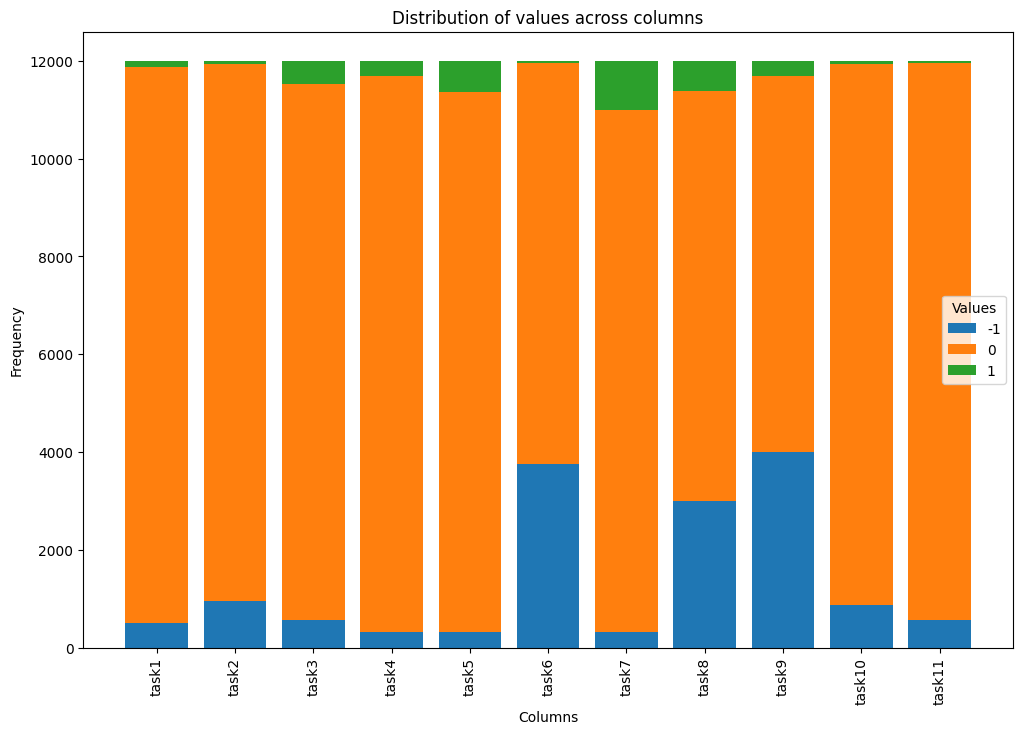

In [ ]:

# Count the occurrences
value_counts = y.apply(pd.Series.value_counts).transpose()

# Create an index for each column
index = np.arange(len(y.columns))

# Plot
plt.figure(figsize=(12,8))

plt.bar(index, value_counts[-1], label='-1')
plt.bar(index, value_counts[0], bottom=value_counts[-1], label='0')
plt.bar(index, value_counts[1], bottom=value_counts[-1]+value_counts[0], label='1')

plt.xlabel('Columns')
plt.ylabel('Frequency')
plt.title('Distribution of values across columns')
plt.xticks(index, y.columns, rotation=90)
plt.legend(title='Values')

plt.show()

In [ ]:
# real numbers for all category
counts = y.apply(lambda x: x.value_counts()).T.fillna(0)

# Print the counts
print(counts)

          -1      0     1
task1    510  11368   122
task2    950  10990    60
task3    561  10977   462
task4    316  11368   316
task5    325  11038   637
task6   3756   8196    48
task7    310  10686  1004
task8   3002   8374   624
task9   4005   7689   306
task10   880  11047    73
task11   564  11390    46


In [ ]:
# total
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{-1: 15179, 0: 113123, 1: 3698}

# FFNN for separated TASK with adaptive loss function

## Data prep for task-specific models

In [ ]:
import torch
from sklearn.model_selection import train_test_split

In [ ]:
# data_train_comb-->X and y si y are your data
X = data_train_comb

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
y_train.columns = y_train.columns.astype(str)
y_test.columns = y_test.columns.astype(str)


In [ ]:
y_test_1 = y_test['task1']
y_test_2 = y_test['task2']
y_test_3 = y_test['task3']
y_test_4 = y_test['task4']
y_test_5 = y_test['task5']
y_test_6 = y_test['task6']
y_test_7 = y_test['task7']
y_test_8 = y_test['task8']
y_test_9 = y_test['task9']
y_test_10 = y_test['task10']
y_test_11 = y_test['task11']

In [ ]:
y_1 = y_train['task1']
y_2 = y_train['task2']
y_3 = y_train['task3']
y_4 = y_train['task4']
y_5 = y_train['task5']
y_6 = y_train['task6']
y_7 = y_train['task7']
y_8 = y_train['task8']
y_9 = y_train['task9']
y_10 = y_train['task10']
y_11 = y_train['task11']

#X_train has the same samples


## TASK_1 - ok

In [ ]:
# unique and couunts for TASK_1
unique, counts = np.unique(y_1, return_counts=True) # rename!!!!!!!!!!!!!!!!!!!!
dict(zip(unique, counts))
# 9079 in total for training

{-1: 419, 0: 9079, 1: 102}

In [ ]:
minus_1 = 9079 / 419
zero = 9079/ 9079
plus_1 = 9079 / 102

In [ ]:
minus_1, zero, plus_1

(21.668257756563246, 1.0, 89.00980392156863)

In [ ]:
def convert_to_one_hot(df, column_name):
  df = pd.DataFrame(df.copy())  # Ensure we are working on a copy
  df_temp = pd.get_dummies(df[column_name])  # Create one-hot encoded columns, exclude first category
  df_temp = df_temp.astype(int)  # Convert True/False to 1/0
  df = pd.concat([df, df_temp], axis=1)  # Concatenate the original and encoded columns
  del df[column_name]  # Remove the original categorical column
  return df


In [ ]:
y_1

9182     0
11091    0
6428     0
288      0
2626     0
        ..
11964    0
5191     0
5390     0
860      0
7270     0
Name: task1, Length: 9600, dtype: int64

In [ ]:
y_hot = convert_to_one_hot(y_1, 'task1')# rename!!!!!!!!!!!!!!!!!!!!!!
y_hot

-1  0  1
9182    0  1  0
11091   0  1  0
6428    0  1  0
288     0  1  0
2626    0  1  0
...    .. .. ..
11964   0  1  0
5191    0  1  0
5390    0  1  0
860     0  1  0
7270    0  1  0

[9600 rows x 3 columns]

In [ ]:
y_test_hot = convert_to_one_hot(y_test_1, 'task1') # rename!!!!!!!!!!!!!!!!!!!!!!
y_test_hot

-1  0  1
1935    0  1  0
6494    0  1  0
1720    0  1  0
9120    0  1  0
360     0  1  0
...    .. .. ..
1195    0  1  0
11877   0  1  0
5421    0  1  0
3855    0  1  0
4414    0  1  0

[2400 rows x 3 columns]

### Task_1_model


In [ ]:
# Define class weights
class_weight = {0: minus_1,  # weight for class -1
                1: zero,  # weight for class 0
                2: plus_1}   # weight for class +1

# Set random
tf.random.set_seed(42)

insurance_norm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu', input_shape=(1385,)),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(75, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # use softmax for multi-class classification
])

# Compile the model
insurance_norm_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, use_ema=True, ema_momentum=0.9),
                             metrics=["accuracy", tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3, average='macro')])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=13,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=13,
)


# Fit the model with callbacks
history = insurance_norm_model_1.fit(X_train, y_hot, epochs=35, batch_size=32,
                                  validation_data=(X_test, y_test_hot),
                                  class_weight=class_weight,
                                  callbacks=[early_stopping, reduce_lr])

# adjusted: learning rate:0.001, patience:10, drop out: 0.2

Epoch 1/35
300/300 [==============================] - 4s 9ms/step - loss: 3.2328 - accuracy: 0.7791 - recall_11: 0.1391 - f1_score: 0.3181 - val_loss: 1.0849 - val_accuracy: 0.4392 - val_recall_11: 0.0000e+00 - val_f1_score: 0.2360 - lr: 0.0010
Epoch 2/35
300/300 [==============================] - 3s 9ms/step - loss: 3.1176 - accuracy: 0.4460 - recall_11: 0.0105 - f1_score: 0.2420 - val_loss: 1.0615 - val_accuracy: 0.5458 - val_recall_11: 4.1667e-04 - val_f1_score: 0.2821 - lr: 0.0010
Epoch 3/35
300/300 [==============================] - 3s 10ms/step - loss: 3.0813 - accuracy: 0.4933 - recall_11: 0.0244 - f1_score: 0.2574 - val_loss: 1.0849 - val_accuracy: 0.3575 - val_recall_11: 0.0037 - val_f1_score: 0.2031 - lr: 0.0010
Epoch 4/35
300/300 [==============================] - 2s 8ms/step - loss: 2.9709 - accuracy: 0.4710 - recall_11: 0.0485 - f1_score: 0.2584 - val_loss: 1.0196 - val_accuracy: 0.5017 - val_recall_11: 0.0625 - val_f1_score: 0.2589 - lr: 0.0010
Epoch 5/35
300/300 [=======

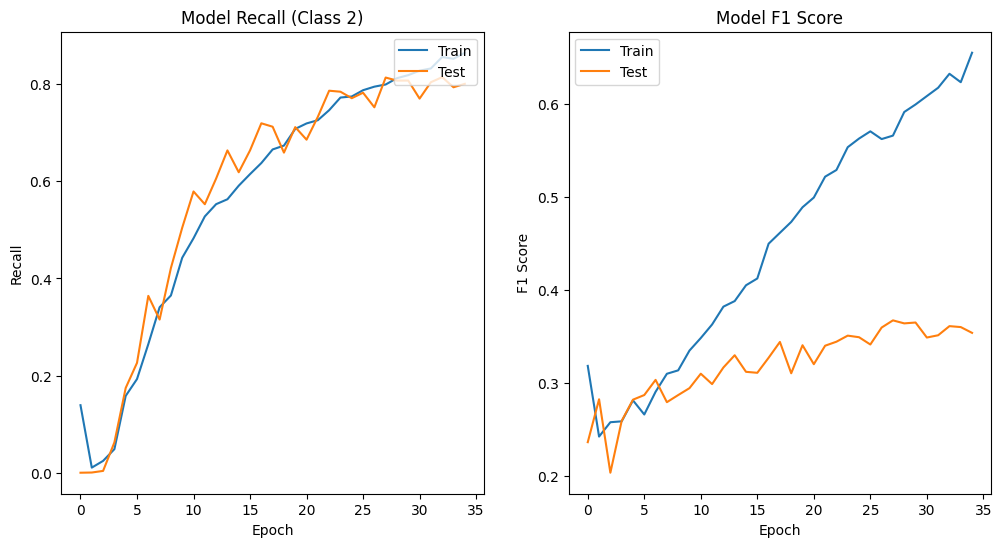

In [ ]:

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_11'])  # change the name!!!!!!!
plt.plot(history.history['val_recall_11']) #change the name!!!!
plt.title('Model Recall (Class 2)')  #
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')




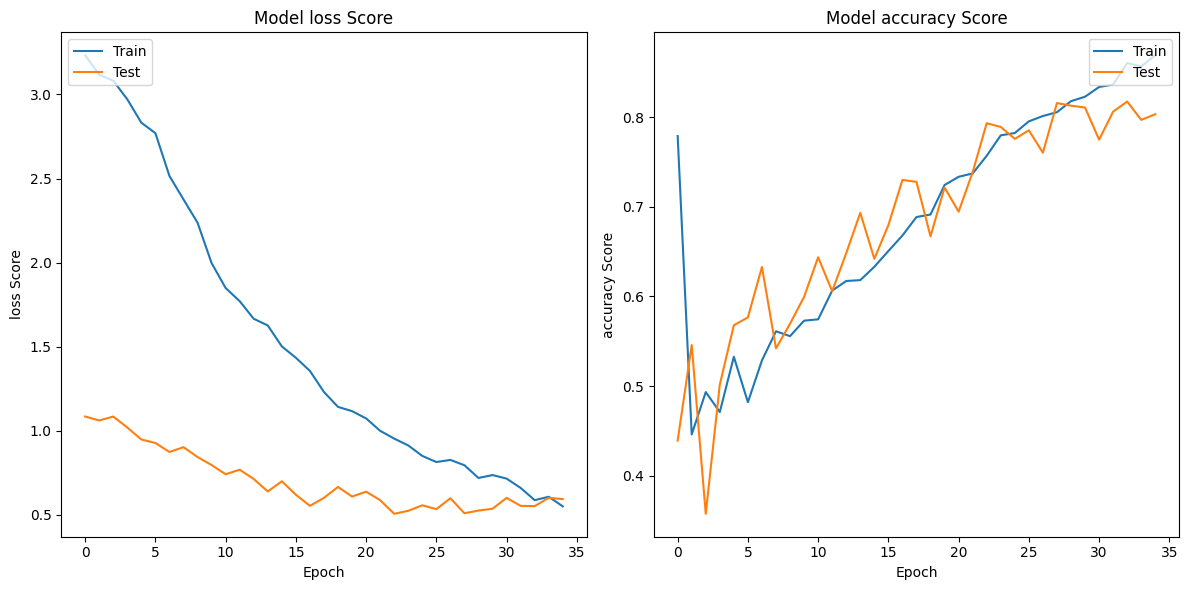

In [ ]:
# Plot training & validation loss score values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Score')
plt.ylabel('loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy score values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Score')
plt.ylabel('accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
prediction = insurance_norm_model_1.predict(smiles_test_comb)
prediction.shape

185/185 [==============================] - 1s 2ms/step


(5896, 3)

In [ ]:
pred = pd.DataFrame(prediction)
pred.rename(columns={0: -1, 1: 0, 2: 1}, inplace=True)
pred['task1'] = pred.idxmax(axis=1)
pred = pred['task1']
pred = pd.DataFrame(pred)
# Assuming pred is your DataFrame
pred.to_excel("pred_1.xlsx", index=True) # RENAME!!!!!!!!!!!

## TASK 2

In [ ]:
# unique and couunt
unique, counts = np.unique(y_2, return_counts=True) # rename!!!!!!!!!!!!!!!!!!!!
dict(zip(unique, counts))
# 8783 in total for training

{-1: 768, 0: 8783, 1: 49}

In [ ]:
minus_1 = 8783 / 768
zero = 8783/ 8783
plus_1 = 8783 / 49

In [ ]:
minus_1, zero, plus_1

(11.436197916666666, 1.0, 179.24489795918367)

In [ ]:
def convert_to_one_hot(df, column_name):
  df = pd.DataFrame(df.copy())  # Ensure we are working on a copy
  df_temp = pd.get_dummies(df[column_name])  # Create one-hot encoded columns, exclude first category
  df_temp = df_temp.astype(int)  # Convert True/False to 1/0
  df = pd.concat([df, df_temp], axis=1)  # Concatenate the original and encoded columns
  del df[column_name]  # Remove the original categorical column
  return df


In [ ]:
y_2

9182     0
11091    0
6428     0
288      0
2626     0
        ..
11964   -1
5191     0
5390     0
860      0
7270     0
Name: task2, Length: 9600, dtype: int64

In [ ]:
y_hot = convert_to_one_hot(y_2, 'task2')# rename!!!!!!!!!!!!!!!!!!!!!!
y_hot

-1  0  1
9182    0  1  0
11091   0  1  0
6428    0  1  0
288     0  1  0
2626    0  1  0
...    .. .. ..
11964   1  0  0
5191    0  1  0
5390    0  1  0
860     0  1  0
7270    0  1  0

[9600 rows x 3 columns]

In [ ]:
y_test_hot = convert_to_one_hot(y_test_2, 'task2') # rename!!!!!!!!!!!!!!!!!!!!!!
y_test_hot

-1  0  1
1935    0  1  0
6494    1  0  0
1720    1  0  0
9120    0  1  0
360     0  1  0
...    .. .. ..
1195    0  1  0
11877   1  0  0
5421    0  1  0
3855    0  1  0
4414    0  1  0

[2400 rows x 3 columns]

### Task_2_model


In [ ]:
# Define class weights
class_weight = {0: minus_1,  # weight for class -1
                1: zero,  # weight for class 0
                2: plus_1}   # weight for class +1

# Set random
tf.random.set_seed(42)

insurance_norm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu', input_shape=(1385,)),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(75, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # use softmax for multi-class classification
])

# Compile the model
insurance_norm_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, use_ema=True, ema_momentum=0.9),
                             metrics=["accuracy", tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3, average='macro')])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=15,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=15,
)


# Fit the model with callbacks
history = insurance_norm_model_1.fit(X_train, y_hot, epochs=35, batch_size=32,
                                  validation_data=(X_test, y_test_hot),
                                  class_weight=class_weight,
                                  callbacks=[early_stopping, reduce_lr])



Epoch 1/35
300/300 [==============================] - 6s 9ms/step - loss: 3.1837 - accuracy: 0.6834 - recall_13: 0.1491 - f1_score: 0.3116 - val_loss: 1.0183 - val_accuracy: 0.5492 - val_recall_13: 0.0021 - val_f1_score: 0.2807 - lr: 0.0010
Epoch 2/35
300/300 [==============================] - 2s 7ms/step - loss: 3.0152 - accuracy: 0.6209 - recall_13: 0.0220 - f1_score: 0.3058 - val_loss: 1.0293 - val_accuracy: 0.5354 - val_recall_13: 0.0021 - val_f1_score: 0.2840 - lr: 0.0010
Epoch 3/35
300/300 [==============================] - 3s 9ms/step - loss: 2.9895 - accuracy: 0.6269 - recall_13: 0.0316 - f1_score: 0.3145 - val_loss: 1.0147 - val_accuracy: 0.6237 - val_recall_13: 0.0179 - val_f1_score: 0.3107 - lr: 0.0010
Epoch 4/35
300/300 [==============================] - 3s 9ms/step - loss: 2.9374 - accuracy: 0.6381 - recall_13: 0.0838 - f1_score: 0.3212 - val_loss: 0.9939 - val_accuracy: 0.5475 - val_recall_13: 0.0812 - val_f1_score: 0.2902 - lr: 0.0010
Epoch 5/35
300/300 [================

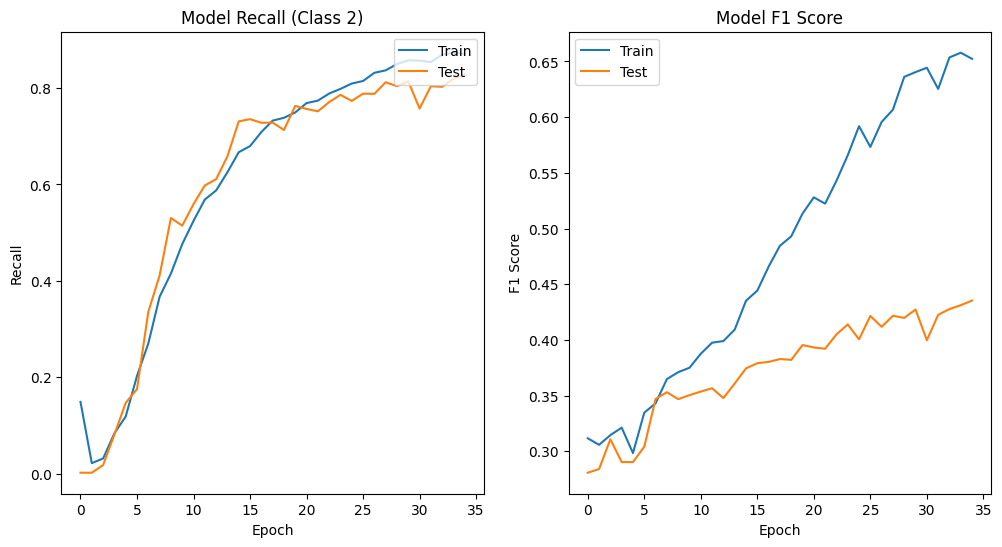

In [ ]:

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_13'])  # change the name!!!!!!!
plt.plot(history.history['val_recall_13']) #change the name!!!!
plt.title('Model Recall (Class 2)')  #
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')




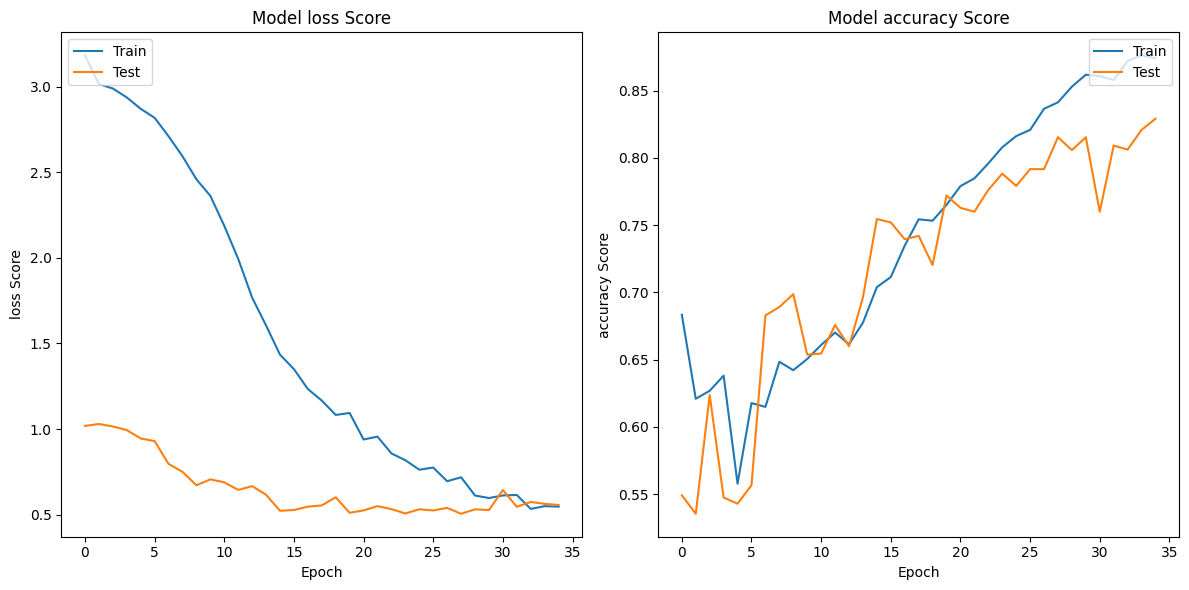

In [ ]:
# Plot training & validation loss score values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Score')
plt.ylabel('loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy score values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Score')
plt.ylabel('accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
prediction = insurance_norm_model_1.predict(smiles_test_comb)
prediction.shape

185/185 [==============================] - 1s 3ms/step


(5896, 3)

In [ ]:
pred = pd.DataFrame(prediction)
pred.rename(columns={0: -1, 1: 0, 2: 1}, inplace=True)
pred['task1'] = pred.idxmax(axis=1)
pred = pred['task1']
pred = pd.DataFrame(pred)
# pred is your DataFrame
pred.to_excel("pred_2.xlsx", index=True) # RENAME!!!!!!!!!!!

## TASK 3

In [ ]:
# unique and counts
unique, counts = np.unique(y_3, return_counts=True) # rename!!!!!!!!!!!!!!!!!!!!
dict(zip(unique, counts))
# 8787 in total for training

{-1: 454, 0: 8787, 1: 359}

In [ ]:
minus_1 = 8787 / 454
zero = 8787/ 8787
plus_1 = 8787 / 359

In [ ]:
minus_1, zero, plus_1

(19.354625550660792, 1.0, 24.47632311977716)

In [ ]:
def convert_to_one_hot(df, column_name):
  df = pd.DataFrame(df.copy())  # Ensure we are working on a copy
  df_temp = pd.get_dummies(df[column_name])  # Create one-hot encoded columns, exclude first category
  df_temp = df_temp.astype(int)  # Convert True/False to 1/0
  df = pd.concat([df, df_temp], axis=1)  # Concatenate the original and encoded columns
  del df[column_name]  # Remove the original categorical column
  return df


In [ ]:
y_3

9182     0
11091    0
6428     0
288      0
2626     0
        ..
11964    0
5191     0
5390     0
860      0
7270     0
Name: task3, Length: 9600, dtype: int64

In [ ]:
y_hot = convert_to_one_hot(y_3, 'task3')# rename!!!!!!!!!!!!!!!!!!!!!!
y_hot

-1  0  1
9182    0  1  0
11091   0  1  0
6428    0  1  0
288     0  1  0
2626    0  1  0
...    .. .. ..
11964   0  1  0
5191    0  1  0
5390    0  1  0
860     0  1  0
7270    0  1  0

[9600 rows x 3 columns]

In [ ]:
y_test_hot = convert_to_one_hot(y_test_3, 'task3') # rename!!!!!!!!!!!!!!!!!!!!!!
y_test_hot

-1  0  1
1935    0  1  0
6494    0  1  0
1720    0  1  0
9120    0  1  0
360     0  0  1
...    .. .. ..
1195    0  1  0
11877   0  1  0
5421    0  1  0
3855    0  1  0
4414    0  1  0

[2400 rows x 3 columns]

### Task_3_model


In [ ]:
# Define class weights
class_weight = {0: minus_1,  # weight for class -1
                1: zero,  # weight for class 0
                2: plus_1}   # weight for class +1

# Set random
tf.random.set_seed(42)

insurance_norm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu', input_shape=(1385,)),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(75, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # use softmax for multi-class classification
])

# Compile the model
insurance_norm_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, use_ema=True, ema_momentum=0.9),
                             metrics=["accuracy", tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3, average='macro')])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=15,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=15,
)


# Fit the model with callbacks
history = insurance_norm_model_1.fit(X_train, y_hot, epochs=35, batch_size=32,
                                  validation_data=(X_test, y_test_hot),
                                  class_weight=class_weight,
                                  callbacks=[early_stopping, reduce_lr])



Epoch 1/35
300/300 [==============================] - 6s 9ms/step - loss: 2.4986 - accuracy: 0.8359 - recall_14: 0.4419 - f1_score: 0.4770 - val_loss: 0.2541 - val_accuracy: 0.9454 - val_recall_14: 0.8983 - val_f1_score: 0.7128 - lr: 0.0010
Epoch 2/35
300/300 [==============================] - 2s 7ms/step - loss: 1.7337 - accuracy: 0.9154 - recall_14: 0.8747 - f1_score: 0.6038 - val_loss: 0.1517 - val_accuracy: 0.9488 - val_recall_14: 0.9300 - val_f1_score: 0.6911 - lr: 0.0010
Epoch 3/35
300/300 [==============================] - 2s 7ms/step - loss: 1.4869 - accuracy: 0.9440 - recall_14: 0.9227 - f1_score: 0.6897 - val_loss: 0.1196 - val_accuracy: 0.9567 - val_recall_14: 0.9500 - val_f1_score: 0.7306 - lr: 0.0010
Epoch 4/35
300/300 [==============================] - 3s 10ms/step - loss: 1.2635 - accuracy: 0.9538 - recall_14: 0.9414 - f1_score: 0.7442 - val_loss: 0.0869 - val_accuracy: 0.9725 - val_recall_14: 0.9717 - val_f1_score: 0.8329 - lr: 0.0010
Epoch 5/35
300/300 [===============

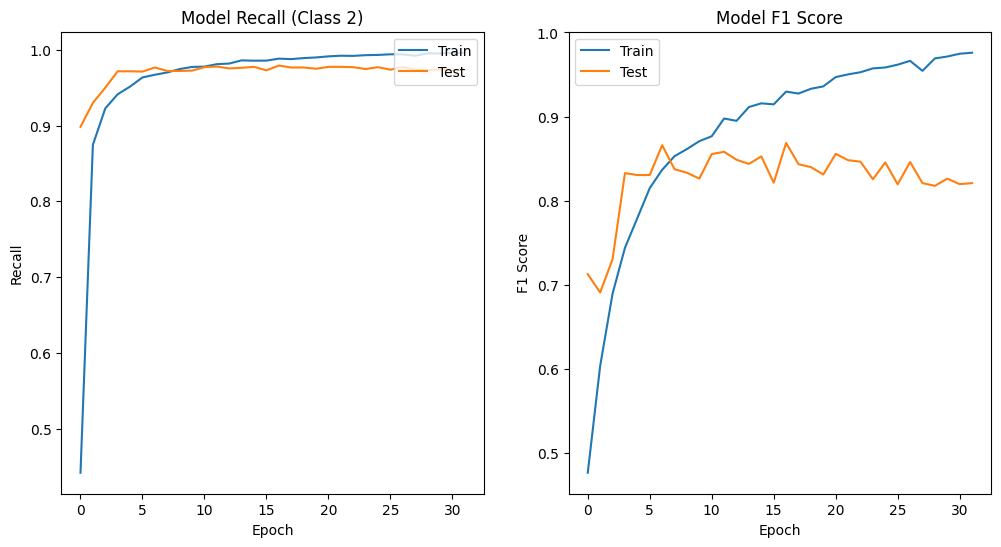

In [ ]:

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_14'])  # change the name!!!!!!!
plt.plot(history.history['val_recall_14']) #change the name!!!!
plt.title('Model Recall (Class 2)')  #
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')




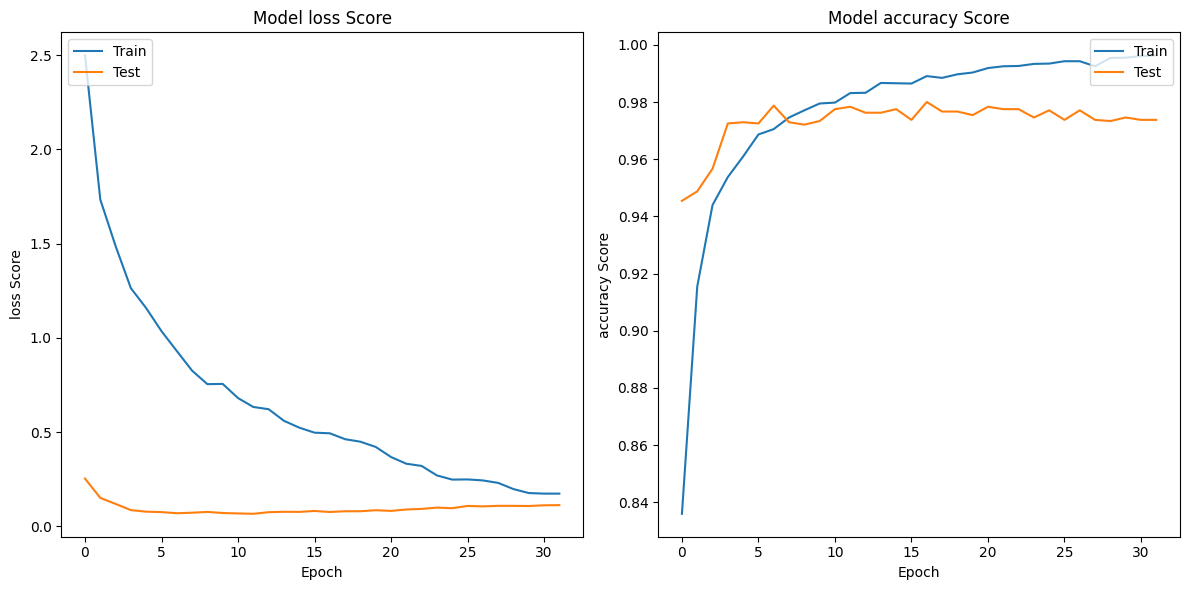

In [ ]:
# Plot training & validation loss score values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Score')
plt.ylabel('loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy score values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Score')
plt.ylabel('accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
prediction = insurance_norm_model_1.predict(smiles_test_comb)
prediction.shape

185/185 [==============================] - 1s 2ms/step


(5896, 3)

In [ ]:
pred = pd.DataFrame(prediction)
pred.rename(columns={0: -1, 1: 0, 2: 1}, inplace=True)
pred['task1'] = pred.idxmax(axis=1)
pred = pred['task1']
pred = pd.DataFrame(pred)
# pred is your DataFrame
pred.to_excel("pred_3.xlsx", index=True) # RENAME!!!!!!!!!!!

## TASK_4

In [ ]:
# unique and counts
unique, counts = np.unique(y_4, return_counts=True) # rename!!!!!!!!!!!!!!!!!!!!
dict(zip(unique, counts))
# 9079 in total for training

{-1: 263, 0: 9079, 1: 258}

In [ ]:
minus_1 = 9079 / 263
zero = 9079/ 9079
plus_1 = 9079 / 258

In [ ]:
minus_1, zero, plus_1

(34.52091254752852, 1.0, 35.189922480620154)

In [ ]:
def convert_to_one_hot(df, column_name):
  df = pd.DataFrame(df.copy())  # Ensure we are working on a copy
  df_temp = pd.get_dummies(df[column_name])  # Create one-hot encoded columns, exclude first category
  df_temp = df_temp.astype(int)  # Convert True/False to 1/0
  df = pd.concat([df, df_temp], axis=1)  # Concatenate the original and encoded columns
  del df[column_name]  # Remove the original categorical column
  return df


In [ ]:
y_hot = convert_to_one_hot(y_4, 'task4')# rename!!!!!!!!!!!!!!!!!!!!!!
y_hot

-1  0  1
9182    0  1  0
11091   0  1  0
6428    0  1  0
288     0  1  0
2626    0  1  0
...    .. .. ..
11964   0  1  0
5191    0  1  0
5390    0  1  0
860     0  1  0
7270    0  1  0

[9600 rows x 3 columns]

In [ ]:
y_test_hot = convert_to_one_hot(y_test_4, 'task4') # rename!!!!!!!!!!!!!!!!!!!!!!
y_test_hot

-1  0  1
1935    0  1  0
6494    0  1  0
1720    0  1  0
9120    0  1  0
360     0  1  0
...    .. .. ..
1195    0  1  0
11877   0  1  0
5421    0  1  0
3855    0  1  0
4414    0  1  0

[2400 rows x 3 columns]

In [ ]:
# Define class weights
class_weight = {0: minus_1,  # weight for class -1
                1: zero,  # weight for class 0
                2: plus_1}   # weight for class +1

# Set random
tf.random.set_seed(42)

insurance_norm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu', input_shape=(1385,)),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(75, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # use softmax for multi-class classification
])

# Compile the model
insurance_norm_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, use_ema=True, ema_momentum=0.9),
                             metrics=["accuracy", tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3, average='macro')])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=15,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=15,
)


# Fit the model with callbacks
history = insurance_norm_model_1.fit(X_train, y_hot, epochs=35, batch_size=32,
                                  validation_data=(X_test, y_test_hot),
                                  class_weight=class_weight,
                                  callbacks=[early_stopping, reduce_lr])

Epoch 1/35
300/300 [==============================] - 6s 13ms/step - loss: 3.1927 - accuracy: 0.7183 - recall_15: 0.0721 - f1_score: 0.3110 - val_loss: 1.0996 - val_accuracy: 0.2492 - val_recall_15: 0.0000e+00 - val_f1_score: 0.1561 - lr: 0.0010
Epoch 2/35
300/300 [==============================] - 3s 10ms/step - loss: 3.1088 - accuracy: 0.4369 - recall_15: 0.0032 - f1_score: 0.2358 - val_loss: 1.0955 - val_accuracy: 0.3096 - val_recall_15: 0.0000e+00 - val_f1_score: 0.1885 - lr: 0.0010
Epoch 3/35
300/300 [==============================] - 3s 9ms/step - loss: 3.0966 - accuracy: 0.3699 - recall_15: 0.0012 - f1_score: 0.2183 - val_loss: 1.1259 - val_accuracy: 0.1179 - val_recall_15: 0.0000e+00 - val_f1_score: 0.0925 - lr: 0.0010
Epoch 4/35
300/300 [==============================] - 2s 7ms/step - loss: 3.0665 - accuracy: 0.4879 - recall_15: 0.0129 - f1_score: 0.2650 - val_loss: 1.1061 - val_accuracy: 0.2308 - val_recall_15: 4.1667e-04 - val_f1_score: 0.1635 - lr: 0.0010
Epoch 5/35
300/300

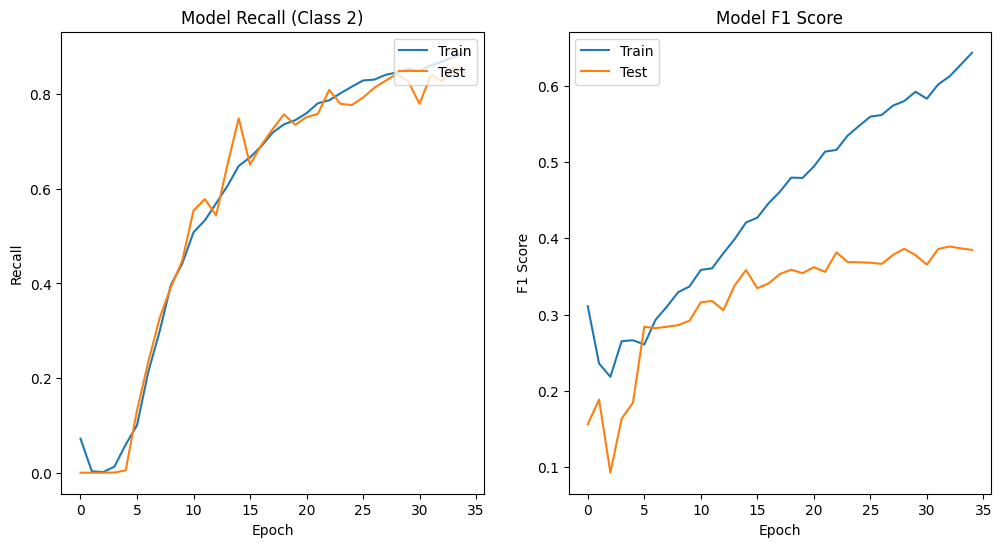

In [ ]:

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_15'])  # Assuming 'recall_2' is for the class you're interested in
plt.plot(history.history['val_recall_15'])
plt.title('Model Recall (Class 2)')  # Update title with relevant class name
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')




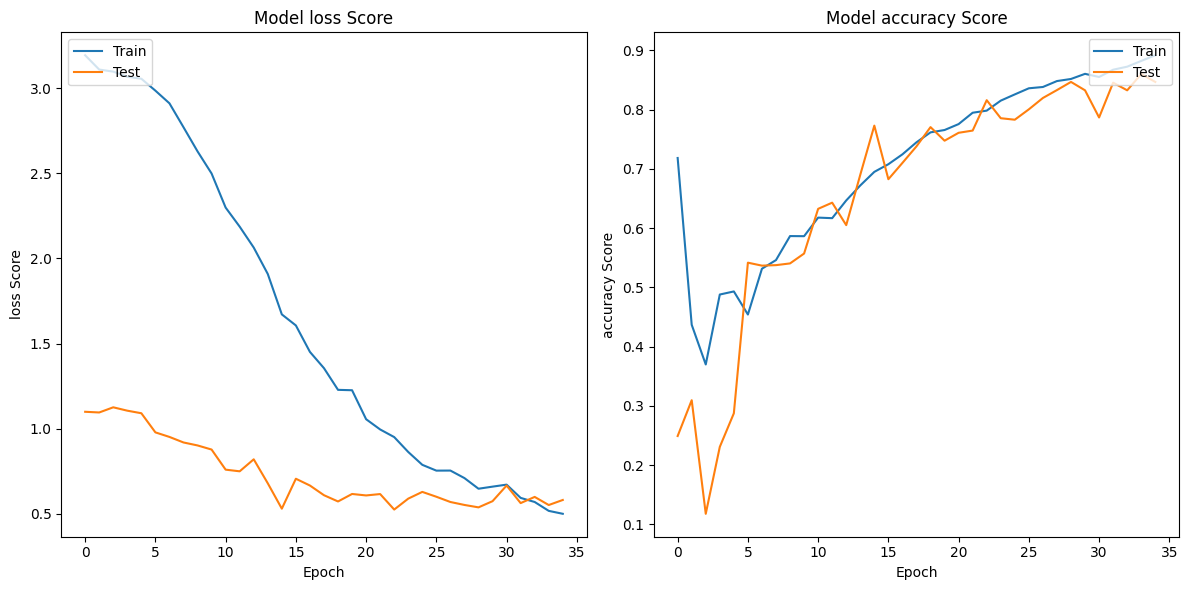

In [ ]:
# Plot training & validation loss score values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Score')
plt.ylabel('loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy score values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Score')
plt.ylabel('accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
prediction = insurance_norm_model_1.predict(smiles_test_comb)
prediction.shape

185/185 [==============================] - 1s 3ms/step


(5896, 3)

In [ ]:
pred = pd.DataFrame(prediction)
pred.rename(columns={0: -1, 1: 0, 2: 1}, inplace=True)
pred['task1'] = pred.idxmax(axis=1)
pred = pred['task1']
pred = pd.DataFrame(pred)
# Assuming pred is your DataFrame
pred.to_excel("pred_4.xlsx", index=True) # RENAME!!!!!!!!!!!

## TASK_5

In [ ]:
# unique and couunts
unique, counts = np.unique(y_5, return_counts=True) # rename!!!!!!!!!!!!!!!!!!!!
dict(zip(unique, counts))
# 9600 in total for training

{-1: 277, 0: 8791, 1: 532}

In [ ]:
minus_1 = 8791 / 277
zero = 8791/ 8791
plus_1 = 8791 / 532

In [ ]:
minus_1, zero, plus_1

(31.736462093862816, 1.0, 16.524436090225564)

In [ ]:
def convert_to_one_hot(df, column_name):
  df = pd.DataFrame(df.copy())  # Ensure we are working on a copy
  df_temp = pd.get_dummies(df[column_name])  # Create one-hot encoded columns, exclude first category
  df_temp = df_temp.astype(int)  # Convert True/False to 1/0
  df = pd.concat([df, df_temp], axis=1)  # Concatenate the original and encoded columns
  del df[column_name]  # Remove the original categorical column
  return df


In [ ]:
y_hot = convert_to_one_hot(y_5, 'task5')# rename!!!!!!!!!!!!!!!!!!!!!!
y_hot

-1  0  1
9182    0  1  0
11091   0  1  0
6428    0  1  0
288     0  1  0
2626    0  1  0
...    .. .. ..
11964   0  1  0
5191    0  1  0
5390    0  1  0
860     0  1  0
7270    0  1  0

[9600 rows x 3 columns]

In [ ]:
y_test_hot = convert_to_one_hot(y_test_5, 'task5') # rename!!!!!!!!!!!!!!!!!!!!!!
y_test_hot

-1  0  1
1935    0  1  0
6494    0  1  0
1720    1  0  0
9120    0  1  0
360     0  1  0
...    .. .. ..
1195    0  1  0
11877   0  1  0
5421    0  1  0
3855    0  1  0
4414    0  1  0

[2400 rows x 3 columns]

In [ ]:
# Define class weights
class_weight = {0: minus_1,  # weight for class -1
                1: zero,  # weight for class 0
                2: plus_1}   # weight for class +1

# Set random
tf.random.set_seed(42)

insurance_norm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu', input_shape=(1385,)),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(75, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # use softmax for multi-class classification
])

# Compile the model
insurance_norm_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0005, use_ema=True, ema_momentum=0.9),
                             metrics=["accuracy", tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3, average='macro')])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=20,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=20,
)


# Fit the model with callbacks
history = insurance_norm_model_1.fit(X_train, y_hot, epochs=35, batch_size=32,
                                  validation_data=(X_test, y_test_hot),
                                  class_weight=class_weight,
                                  callbacks=[early_stopping, reduce_lr])

Epoch 1/35
300/300 [==============================] - 6s 11ms/step - loss: 3.0353 - accuracy: 0.5013 - recall_18: 6.2500e-04 - f1_score: 0.2620 - val_loss: 1.0943 - val_accuracy: 0.3562 - val_recall_18: 0.0000e+00 - val_f1_score: 0.2102 - lr: 5.0000e-04
Epoch 2/35
300/300 [==============================] - 3s 10ms/step - loss: 3.0135 - accuracy: 0.4275 - recall_18: 2.0833e-04 - f1_score: 0.2504 - val_loss: 1.0864 - val_accuracy: 0.3817 - val_recall_18: 0.0000e+00 - val_f1_score: 0.2313 - lr: 5.0000e-04
Epoch 3/35
300/300 [==============================] - 2s 8ms/step - loss: 2.9956 - accuracy: 0.4395 - recall_18: 0.0016 - f1_score: 0.2566 - val_loss: 1.0248 - val_accuracy: 0.7292 - val_recall_18: 0.0000e+00 - val_f1_score: 0.3499 - lr: 5.0000e-04
Epoch 4/35
300/300 [==============================] - 4s 13ms/step - loss: 2.9774 - accuracy: 0.5450 - recall_18: 0.0128 - f1_score: 0.2997 - val_loss: 1.0218 - val_accuracy: 0.6192 - val_recall_18: 0.0000e+00 - val_f1_score: 0.3147 - lr: 5.00

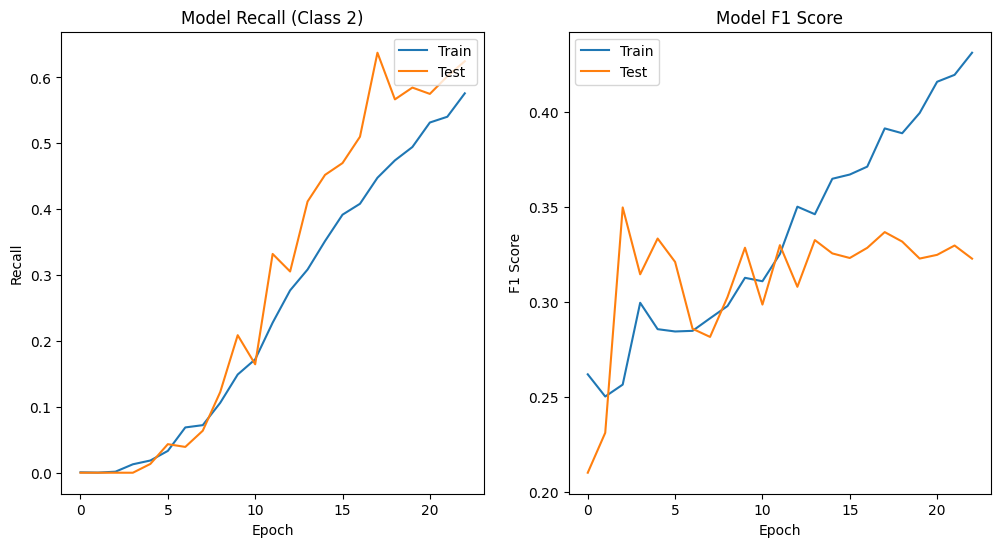

In [ ]:

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_18'])  # Assuming 'recall_2' is for the class you're interested in
plt.plot(history.history['val_recall_18'])
plt.title('Model Recall (Class 2)')  # Update title with relevant class name
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')




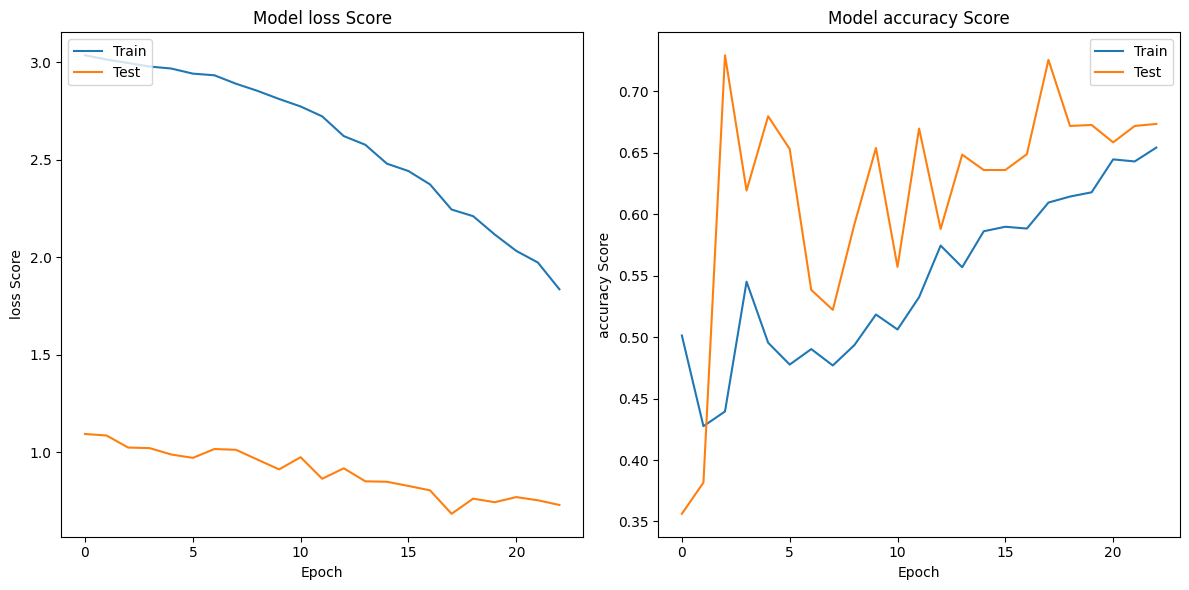

In [ ]:
# Plot training & validation loss score values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Score')
plt.ylabel('loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy score values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Score')
plt.ylabel('accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
prediction = insurance_norm_model_1.predict(smiles_test_comb)
prediction.shape

185/185 [==============================] - 1s 3ms/step


(5896, 3)

In [ ]:
pred = pd.DataFrame(prediction)
pred.rename(columns={0: -1, 1: 0, 2: 1}, inplace=True)
pred['task1'] = pred.idxmax(axis=1)
pred = pred['task1']
pred = pd.DataFrame(pred)
# Assuming pred is your DataFrame
pred.to_excel("pred_5.xlsx", index=True) # RENAME!!!!!!!!!!!

## TASK_6

In [ ]:
# unique and couunts
unique, counts = np.unique(y_6, return_counts=True) # rename!!!!!!!!!!!!!!!!!!!!
dict(zip(unique, counts))
# 9600 in total for training

{-1: 3016, 0: 6548, 1: 36}

In [ ]:
minus_1 = 6548 / 3016
zero = 6548/ 6548
plus_1 = 6548 / 36

In [ ]:
minus_1, zero, plus_1

(2.1710875331564985, 1.0, 181.88888888888889)

In [ ]:
def convert_to_one_hot(df, column_name):
  df = pd.DataFrame(df.copy())  # Ensure we are working on a copy
  df_temp = pd.get_dummies(df[column_name])  # Create one-hot encoded columns, exclude first category
  df_temp = df_temp.astype(int)  # Convert True/False to 1/0
  df = pd.concat([df, df_temp], axis=1)  # Concatenate the original and encoded columns
  del df[column_name]  # Remove the original categorical column
  return df


In [ ]:
y_hot = convert_to_one_hot(y_6, 'task6')# rename!!!!!!!!!!!!!!!!!!!!!!
y_hot

-1  0  1
9182    0  1  0
11091   1  0  0
6428    1  0  0
288     1  0  0
2626    1  0  0
...    .. .. ..
11964   0  1  0
5191    0  1  0
5390    1  0  0
860     0  1  0
7270    0  1  0

[9600 rows x 3 columns]

In [ ]:
y_test_hot = convert_to_one_hot(y_test_6, 'task6') # rename!!!!!!!!!!!!!!!!!!!!!!
y_test_hot

-1  0  1
1935    0  1  0
6494    0  1  0
1720    0  1  0
9120    0  1  0
360     0  1  0
...    .. .. ..
1195    0  1  0
11877   0  1  0
5421    0  1  0
3855    0  1  0
4414    1  0  0

[2400 rows x 3 columns]

In [ ]:
# Define class weights
class_weight = {0: minus_1,  # weight for class -1
                1: zero,  # weight for class 0
                2: plus_1}   # weight for class +1

# Set random
tf.random.set_seed(42)

insurance_norm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu', input_shape=(1385,)),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(75, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # use softmax for multi-class classification
])

# Compile the model
insurance_norm_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, use_ema=True, ema_momentum=0.9),
                             metrics=["accuracy", tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3, average='macro')])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=15,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=15,
)


# Fit the model with callbacks
history = insurance_norm_model_1.fit(X_train, y_hot, epochs=35, batch_size=10,
                                  validation_data=(X_test, y_test_hot),
                                  class_weight=class_weight,
                                  callbacks=[early_stopping, reduce_lr])

Epoch 1/35
960/960 [==============================] - 9s 7ms/step - loss: 2.4195 - accuracy: 0.6187 - recall_23: 0.1646 - f1_score: 0.3602 - val_loss: 0.8861 - val_accuracy: 0.6012 - val_recall_23: 0.0838 - val_f1_score: 0.3951 - lr: 0.0010
Epoch 2/35
960/960 [==============================] - 6s 6ms/step - loss: 2.1591 - accuracy: 0.6134 - recall_23: 0.2086 - f1_score: 0.3903 - val_loss: 0.8767 - val_accuracy: 0.6187 - val_recall_23: 0.1737 - val_f1_score: 0.4042 - lr: 0.0010
Epoch 3/35
960/960 [==============================] - 7s 7ms/step - loss: 2.0552 - accuracy: 0.6145 - recall_23: 0.2868 - f1_score: 0.4072 - val_loss: 0.8379 - val_accuracy: 0.6283 - val_recall_23: 0.2896 - val_f1_score: 0.4118 - lr: 0.0010
Epoch 4/35
960/960 [==============================] - 6s 6ms/step - loss: 1.9462 - accuracy: 0.6274 - recall_23: 0.3823 - f1_score: 0.4286 - val_loss: 0.7633 - val_accuracy: 0.6579 - val_recall_23: 0.4396 - val_f1_score: 0.4370 - lr: 0.0010
Epoch 5/35
960/960 [================

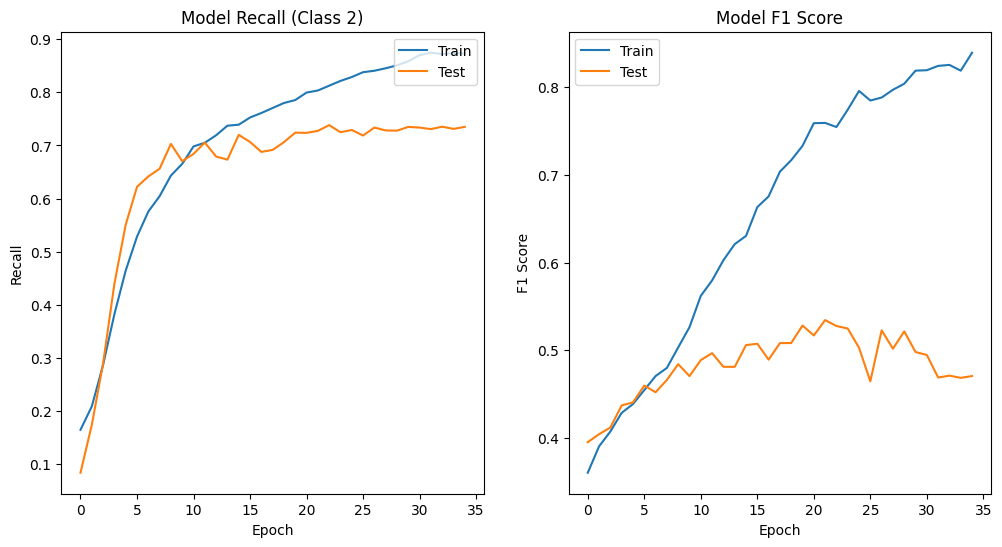

In [ ]:

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_23'])  # Assuming 'recall_2' is for the class you're interested in
plt.plot(history.history['val_recall_23'])
plt.title('Model Recall (Class 2)')  # Update title with relevant class name
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')




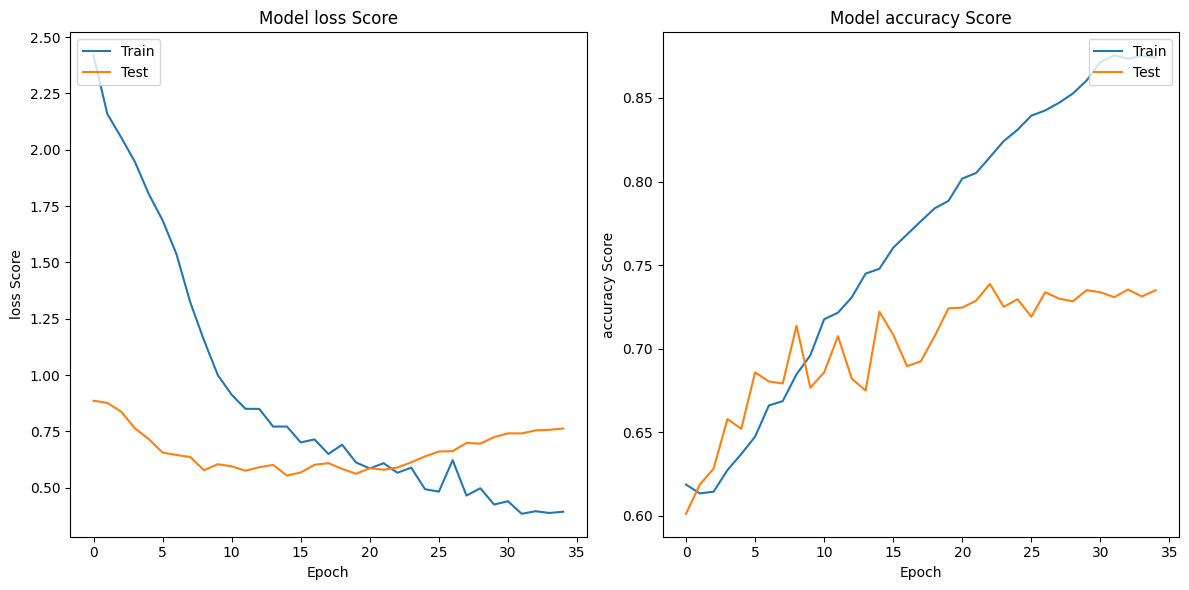

In [ ]:
# Plot training & validation loss score values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Score')
plt.ylabel('loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy score values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Score')
plt.ylabel('accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
prediction = insurance_norm_model_1.predict(smiles_test_comb)
prediction.shape

185/185 [==============================] - 1s 2ms/step


(5896, 3)

In [ ]:
pred = pd.DataFrame(prediction)
pred.rename(columns={0: -1, 1: 0, 2: 1}, inplace=True)
pred['task1'] = pred.idxmax(axis=1)
pred = pred['task1']
pred = pd.DataFrame(pred)
# Assuming pred is your DataFrame
pred.to_excel("pred_6.xlsx", index=True) # RENAME!!!!!!!!!!!

## TASK_7

In [ ]:
# unique and couunts
unique, counts = np.unique(y_7, return_counts=True) # rename!!!!!!!!!!!!!!!!!!!!
dict(zip(unique, counts))
# 9600 in total for training

{-1: 252, 0: 8540, 1: 808}

In [ ]:
minus_1 = 8540 / 252
zero = 8540/ 8540
plus_1 = 8540 / 808

In [ ]:
minus_1, zero, plus_1

(33.888888888888886, 1.0, 10.569306930693068)

In [ ]:
def convert_to_one_hot(df, column_name):
  df = pd.DataFrame(df.copy())  # Ensure we are working on a copy
  df_temp = pd.get_dummies(df[column_name])  # Create one-hot encoded columns, exclude first category
  df_temp = df_temp.astype(int)  # Convert True/False to 1/0
  df = pd.concat([df, df_temp], axis=1)  # Concatenate the original and encoded columns
  del df[column_name]  # Remove the original categorical column
  return df


In [ ]:
y_hot = convert_to_one_hot(y_7, 'task7')# rename!!!!!!!!!!!!!!!!!!!!!!
y_hot

-1  0  1
9182    0  1  0
11091   0  1  0
6428    0  0  1
288     0  1  0
2626    0  1  0
...    .. .. ..
11964   0  1  0
5191    0  1  0
5390    0  1  0
860     0  0  1
7270    0  1  0

[9600 rows x 3 columns]

In [ ]:
y_test_hot = convert_to_one_hot(y_test_7, 'task7') # rename!!!!!!!!!!!!!!!!!!!!!!
y_test_hot

-1  0  1
1935    0  1  0
6494    0  1  0
1720    0  1  0
9120    0  1  0
360     0  1  0
...    .. .. ..
1195    0  1  0
11877   0  1  0
5421    0  0  1
3855    0  1  0
4414    0  1  0

[2400 rows x 3 columns]

In [ ]:
# Define class weights
class_weight = {0: minus_1,  # weight for class -1
                1: zero,  # weight for class 0
                2: plus_1}   # weight for class +1

# Set random
tf.random.set_seed(42)

insurance_norm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu', input_shape=(1385,)),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(75, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # use softmax for multi-class classification
])

# Compile the model
insurance_norm_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, use_ema=True, ema_momentum=0.9),
                             metrics=["accuracy", tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3, average='macro')])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
)


# Fit the model with callbacks
history = insurance_norm_model_1.fit(X_train, y_hot, epochs=35, batch_size=32,
                                  validation_data=(X_test, y_test_hot),
                                  class_weight=class_weight,
                                  callbacks=[early_stopping, reduce_lr])

Epoch 1/35
300/300 [==============================] - 5s 8ms/step - loss: 2.9006 - accuracy: 0.4618 - recall_14: 0.0061 - f1_score: 0.2849 - val_loss: 1.0244 - val_accuracy: 0.6579 - val_recall_14: 0.0025 - val_f1_score: 0.3978 - lr: 0.0010
Epoch 2/35
300/300 [==============================] - 2s 7ms/step - loss: 2.7348 - accuracy: 0.5008 - recall_14: 0.0865 - f1_score: 0.3298 - val_loss: 0.9290 - val_accuracy: 0.6771 - val_recall_14: 0.1529 - val_f1_score: 0.4477 - lr: 0.0010
Epoch 3/35
300/300 [==============================] - 2s 7ms/step - loss: 2.4260 - accuracy: 0.6037 - recall_14: 0.2800 - f1_score: 0.3955 - val_loss: 0.8335 - val_accuracy: 0.7038 - val_recall_14: 0.4450 - val_f1_score: 0.4633 - lr: 0.0010
Epoch 4/35
300/300 [==============================] - 2s 7ms/step - loss: 2.2310 - accuracy: 0.6352 - recall_14: 0.4050 - f1_score: 0.4189 - val_loss: 0.7786 - val_accuracy: 0.7100 - val_recall_14: 0.5471 - val_f1_score: 0.4740 - lr: 0.0010
Epoch 5/35
300/300 [================

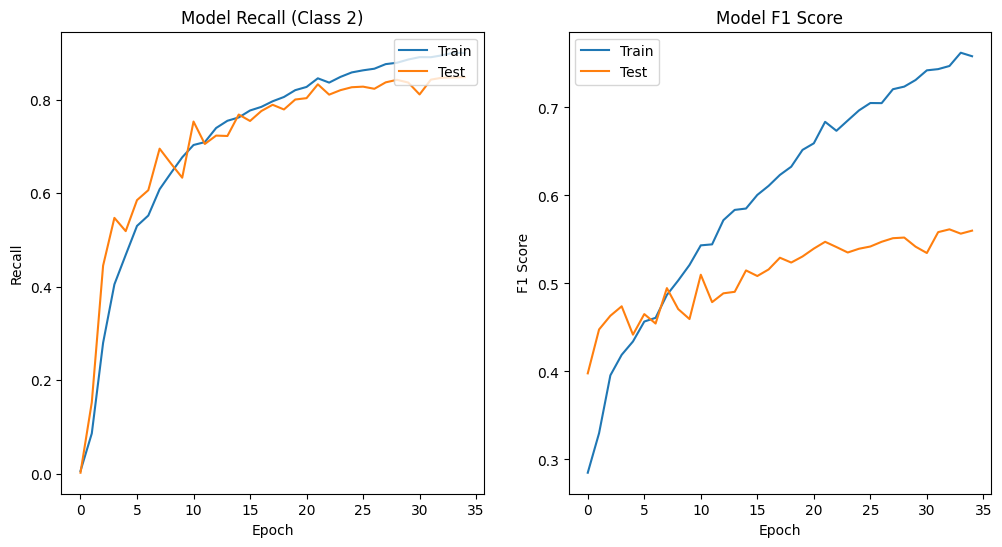

In [ ]:

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_14'])  # Assuming 'recall_2' is for the class you're interested in
plt.plot(history.history['val_recall_14'])
plt.title('Model Recall (Class 2)')  # Update title with relevant class name
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')




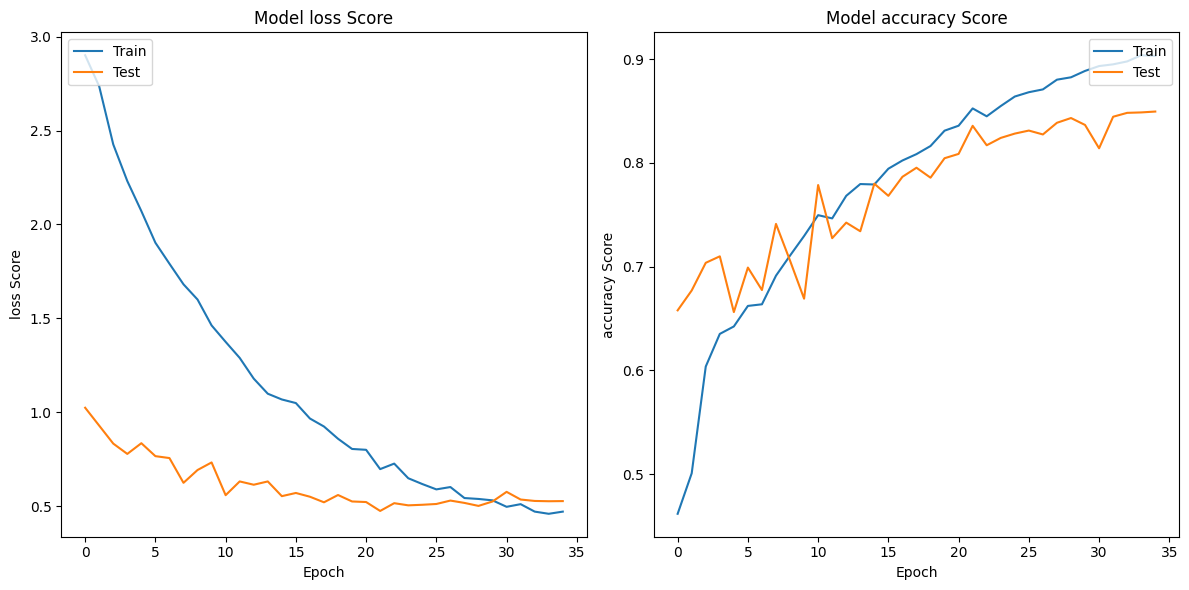

In [ ]:
# Plot training & validation loss score values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Score')
plt.ylabel('loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy score values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Score')
plt.ylabel('accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
prediction = insurance_norm_model_1.predict(smiles_test_comb)
prediction.shape

185/185 [==============================] - 1s 3ms/step


(5896, 3)

In [ ]:
pred = pd.DataFrame(prediction)
pred.rename(columns={0: -1, 1: 0, 2: 1}, inplace=True)
pred['task1'] = pred.idxmax(axis=1)
pred = pred['task1']
pred = pd.DataFrame(pred)
# Assuming pred is your DataFrame
pred.to_excel("pred_7.xlsx", index=True) # RENAME!!!!!!!!!!!

## TASK_8

In [ ]:
# unique and couunts
unique, counts = np.unique(y_8, return_counts=True) # rename!!!!!!!!!!!!!!!!!!!!
dict(zip(unique, counts))
# 9600 in total for training

{-1: 2379, 0: 6719, 1: 502}

In [ ]:
minus_1 = 6719 / 2379
zero = 6719/ 6719
plus_1 = 6719 / 502

In [ ]:
minus_1, zero, plus_1

(2.8242959226565785, 1.0, 13.384462151394422)

In [ ]:
def convert_to_one_hot(df, column_name):
  df = pd.DataFrame(df.copy())  # Ensure we are working on a copy
  df_temp = pd.get_dummies(df[column_name])  # Create one-hot encoded columns, exclude first category
  df_temp = df_temp.astype(int)  # Convert True/False to 1/0
  df = pd.concat([df, df_temp], axis=1)  # Concatenate the original and encoded columns
  del df[column_name]  # Remove the original categorical column
  return df


In [ ]:
y_hot = convert_to_one_hot(y_8, 'task8')# rename!!!!!!!!!!!!!!!!!!!!!!
y_hot

-1  0  1
9182    1  0  0
11091   0  1  0
6428    0  1  0
288     0  1  0
2626    0  1  0
...    .. .. ..
11964   0  1  0
5191    1  0  0
5390    0  1  0
860     0  1  0
7270    0  1  0

[9600 rows x 3 columns]

In [ ]:
y_test_hot = convert_to_one_hot(y_test_8, 'task8') # rename!!!!!!!!!!!!!!!!!!!!!!
y_test_hot

-1  0  1
1935    0  1  0
6494    0  1  0
1720    0  1  0
9120    0  1  0
360     0  1  0
...    .. .. ..
1195    1  0  0
11877   1  0  0
5421    0  1  0
3855    0  1  0
4414    0  1  0

[2400 rows x 3 columns]

In [ ]:
# Define class weights
class_weight = {0: minus_1,  # weight for class -1
                1: zero,  # weight for class 0
                2: plus_1}   # weight for class +1

# Set random
tf.random.set_seed(42)

insurance_norm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu', input_shape=(1385,)),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(75, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # use softmax for multi-class classification
])

# Compile the model
insurance_norm_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, use_ema=True, ema_momentum=0.9),
                             metrics=["accuracy", tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3, average='macro')])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
)


# Fit the model with callbacks
history = insurance_norm_model_1.fit(X_train, y_hot, epochs=35, batch_size=32,
                                  validation_data=(X_test, y_test_hot),
                                  class_weight=class_weight,
                                  callbacks=[early_stopping, reduce_lr])

Epoch 1/35
300/300 [==============================] - 5s 11ms/step - loss: 2.2541 - accuracy: 0.5802 - recall_15: 0.0356 - f1_score: 0.3672 - val_loss: 0.9711 - val_accuracy: 0.6075 - val_recall_15: 0.0846 - val_f1_score: 0.4409 - lr: 0.0010
Epoch 2/35
300/300 [==============================] - 2s 7ms/step - loss: 2.1011 - accuracy: 0.5505 - recall_15: 0.1977 - f1_score: 0.4228 - val_loss: 0.8820 - val_accuracy: 0.6121 - val_recall_15: 0.3275 - val_f1_score: 0.4843 - lr: 0.0010
Epoch 3/35
300/300 [==============================] - 2s 6ms/step - loss: 1.9387 - accuracy: 0.5659 - recall_15: 0.3384 - f1_score: 0.4660 - val_loss: 0.8464 - val_accuracy: 0.6067 - val_recall_15: 0.4588 - val_f1_score: 0.5109 - lr: 0.0010
Epoch 4/35
300/300 [==============================] - 2s 7ms/step - loss: 1.7992 - accuracy: 0.5913 - recall_15: 0.4247 - f1_score: 0.4974 - val_loss: 0.7941 - val_accuracy: 0.6371 - val_recall_15: 0.5433 - val_f1_score: 0.5329 - lr: 0.0010
Epoch 5/35
300/300 [===============

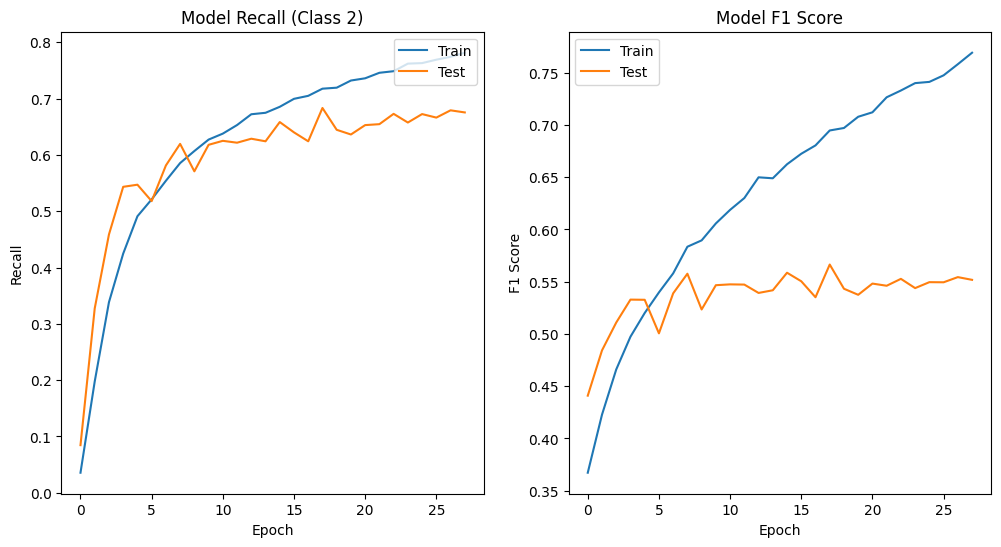

In [ ]:

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_15'])  # Assuming 'recall_2' is for the class you're interested in
plt.plot(history.history['val_recall_15'])
plt.title('Model Recall (Class 2)')  # Update title with relevant class name
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')




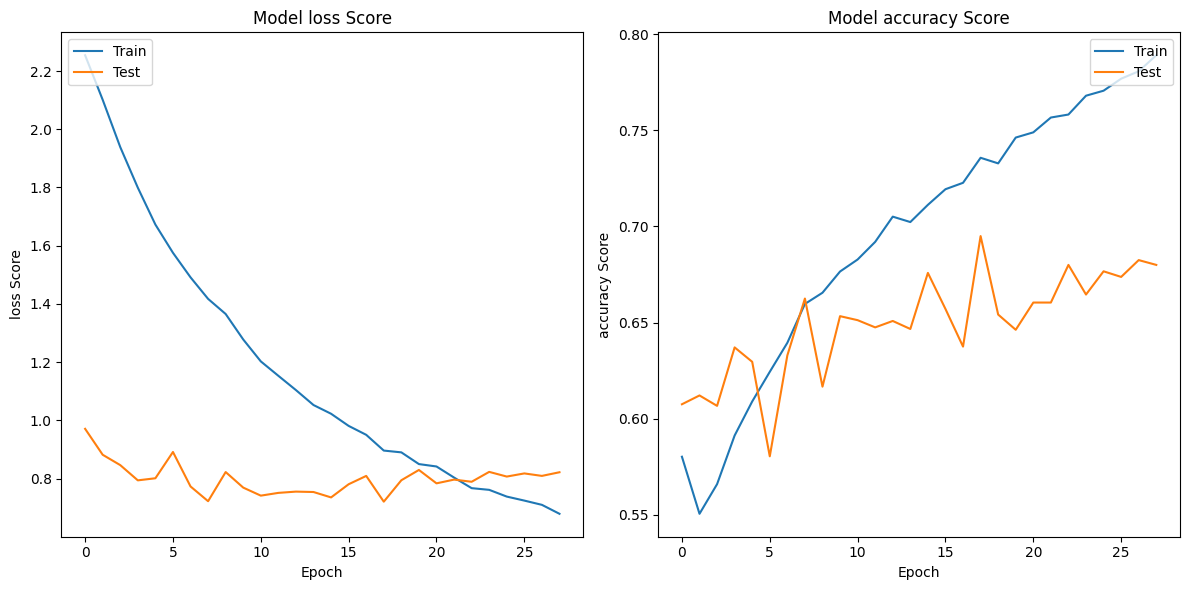

In [ ]:
# Plot training & validation loss score values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Score')
plt.ylabel('loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy score values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Score')
plt.ylabel('accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
prediction = insurance_norm_model_1.predict(smiles_test_comb)
prediction.shape

185/185 [==============================] - 1s 3ms/step


(5896, 3)

In [ ]:
pred = pd.DataFrame(prediction)
pred.rename(columns={0: -1, 1: 0, 2: 1}, inplace=True)
pred['task1'] = pred.idxmax(axis=1)
pred = pred['task1']
pred = pd.DataFrame(pred)
# Assuming pred is your DataFrame
pred.to_excel("pred_8.xlsx", index=True) # RENAME!!!!!!!!!!!

## TASK_9

In [ ]:
# unique and couunts
unique, counts = np.unique(y_9, return_counts=True) # rename!!!!!!!!!!!!!!!!!!!!
dict(zip(unique, counts))
# 9600 in total for training

In [ ]:
minus_1 = 6165 / 3186
zero = 6165/ 6719
plus_1 = 6165 / 249

In [ ]:
minus_1, zero, plus_1

(1.9350282485875707, 0.9175472540556631, 24.759036144578314)

In [ ]:
def convert_to_one_hot(df, column_name):
  df = pd.DataFrame(df.copy())  # Ensure we are working on a copy
  df_temp = pd.get_dummies(df[column_name])  # Create one-hot encoded columns, exclude first category
  df_temp = df_temp.astype(int)  # Convert True/False to 1/0
  df = pd.concat([df, df_temp], axis=1)  # Concatenate the original and encoded columns
  del df[column_name]  # Remove the original categorical column
  return df


In [ ]:
y_hot = convert_to_one_hot(y_9, 'task9')# rename!!!!!!!!!!!!!!!!!!!!!!
y_hot

-1  0  1
9182    1  0  0
11091   0  1  0
6428    0  1  0
288     0  1  0
2626    0  1  0
...    .. .. ..
11964   0  1  0
5191    1  0  0
5390    0  1  0
860     0  1  0
7270    1  0  0

[9600 rows x 3 columns]

In [ ]:
y_test_hot = convert_to_one_hot(y_test_9, 'task9') # rename!!!!!!!!!!!!!!!!!!!!!!
y_test_hot

-1  0  1
1935    1  0  0
6494    0  1  0
1720    0  1  0
9120    0  1  0
360     0  1  0
...    .. .. ..
1195    1  0  0
11877   1  0  0
5421    0  1  0
3855    1  0  0
4414    0  1  0

[2400 rows x 3 columns]

In [ ]:
# Define class weights
class_weight = {0: minus_1,  # weight for class -1
                1: zero,  # weight for class 0
                2: plus_1}   # weight for class +1

# Set random
tf.random.set_seed(42)

insurance_norm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu', input_shape=(1385,)),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(75, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # use softmax for multi-class classification
])

# Compile the model
insurance_norm_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, use_ema=True, ema_momentum=0.9),
                             metrics=["accuracy", tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3, average='macro')])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
)


# Fit the model with callbacks
history = insurance_norm_model_1.fit(X_train, y_hot, epochs=35, batch_size=32,
                                  validation_data=(X_test, y_test_hot),
                                  class_weight=class_weight,
                                  callbacks=[early_stopping, reduce_lr])

Epoch 1/35
300/300 [==============================] - 7s 15ms/step - loss: 2.0068 - accuracy: 0.5297 - recall_16: 0.1238 - f1_score: 0.3937 - val_loss: 0.9236 - val_accuracy: 0.6371 - val_recall_16: 0.2308 - val_f1_score: 0.4737 - lr: 0.0010
Epoch 2/35
300/300 [==============================] - 4s 12ms/step - loss: 1.8792 - accuracy: 0.5608 - recall_16: 0.2544 - f1_score: 0.4344 - val_loss: 0.8525 - val_accuracy: 0.6275 - val_recall_16: 0.4050 - val_f1_score: 0.4820 - lr: 0.0010
Epoch 3/35
300/300 [==============================] - 3s 11ms/step - loss: 1.7794 - accuracy: 0.5798 - recall_16: 0.3614 - f1_score: 0.4549 - val_loss: 0.8856 - val_accuracy: 0.6004 - val_recall_16: 0.4246 - val_f1_score: 0.4789 - lr: 0.0010
Epoch 4/35
300/300 [==============================] - 4s 12ms/step - loss: 1.6823 - accuracy: 0.5942 - recall_16: 0.4220 - f1_score: 0.4711 - val_loss: 0.7946 - val_accuracy: 0.6346 - val_recall_16: 0.5317 - val_f1_score: 0.4845 - lr: 0.0010
Epoch 5/35
300/300 [============

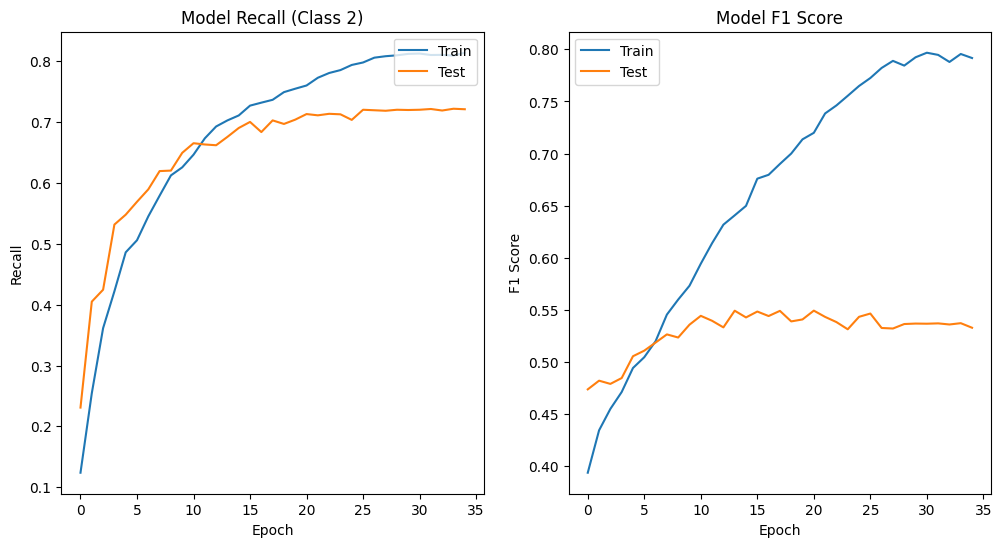

In [ ]:

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_16'])  # Assuming 'recall_2' is for the class you're interested in
plt.plot(history.history['val_recall_16'])
plt.title('Model Recall (Class 2)')  # Update title with relevant class name
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')




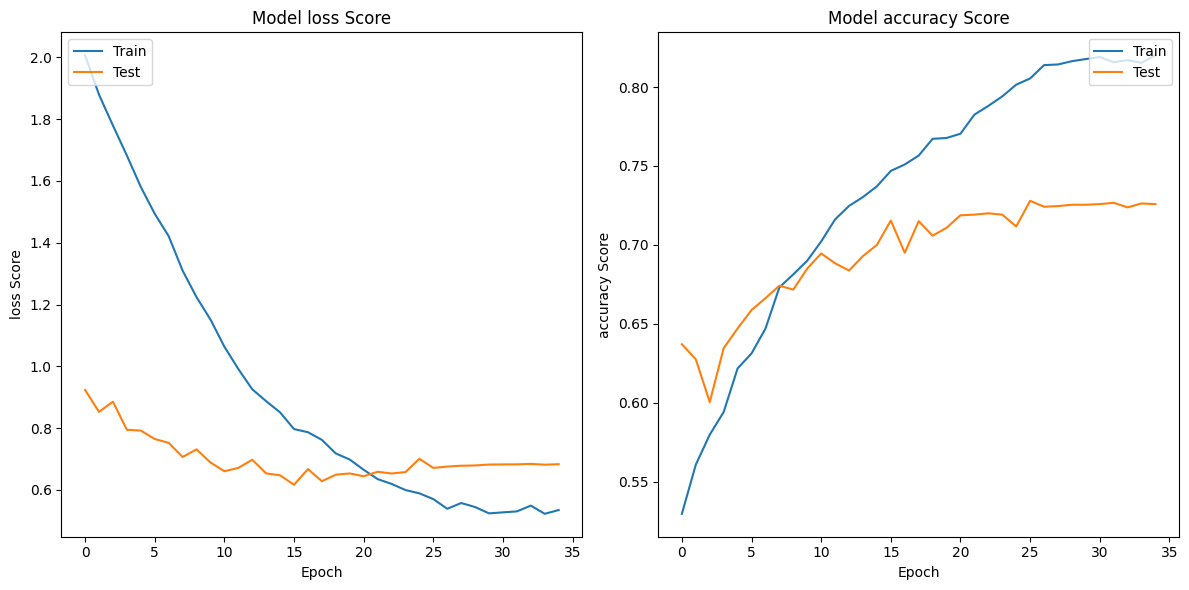

In [ ]:
# Plot training & validation loss score values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Score')
plt.ylabel('loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy score values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Score')
plt.ylabel('accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
prediction = insurance_norm_model_1.predict(smiles_test_comb)
prediction.shape

185/185 [==============================] - 0s 2ms/step


(5896, 3)

In [ ]:
pred = pd.DataFrame(prediction)
pred.rename(columns={0: -1, 1: 0, 2: 1}, inplace=True)
pred['task1'] = pred.idxmax(axis=1)
pred = pred['task1']
pred = pd.DataFrame(pred)
# Assuming pred is your DataFrame
pred.to_excel("pred_9.xlsx", index=True) # RENAME!!!!!!!!!!!

## TASK_10

In [ ]:
# unique and couunts
unique, counts = np.unique(y_10, return_counts=True) # rename!!!!!!!!!!!!!!!!!!!!
dict(zip(unique, counts))
# 9600 in total for training

{-1: 715, 0: 8822, 1: 63}

In [ ]:
minus_1 = 8822 / 715
zero = 8822/ 8822
plus_1 = 8822 / 63

In [ ]:
minus_1, zero, plus_1

(12.338461538461539, 1.0, 140.03174603174602)

In [ ]:
def convert_to_one_hot(df, column_name):
  df = pd.DataFrame(df.copy())  # Ensure we are working on a copy
  df_temp = pd.get_dummies(df[column_name])  # Create one-hot encoded columns, exclude first category
  df_temp = df_temp.astype(int)  # Convert True/False to 1/0
  df = pd.concat([df, df_temp], axis=1)  # Concatenate the original and encoded columns
  del df[column_name]  # Remove the original categorical column
  return df


In [ ]:
y_hot = convert_to_one_hot(y_10, 'task10')# rename!!!!!!!!!!!!!!!!!!!!!!
y_hot

-1  0  1
9182    0  1  0
11091   0  1  0
6428    0  1  0
288     0  1  0
2626    1  0  0
...    .. .. ..
11964   0  1  0
5191    0  1  0
5390    0  1  0
860     0  1  0
7270    0  1  0

[9600 rows x 3 columns]

In [ ]:
y_test_hot = convert_to_one_hot(y_test_10, 'task10') # rename!!!!!!!!!!!!!!!!!!!!!!
y_test_hot

-1  0  1
1935    0  1  0
6494    0  1  0
1720    0  1  0
9120    0  1  0
360     0  1  0
...    .. .. ..
1195    0  1  0
11877   0  1  0
5421    0  1  0
3855    0  1  0
4414    0  1  0

[2400 rows x 3 columns]

In [ ]:
# Define class weights
class_weight = {0: minus_1,  # weight for class -1
                1: zero,  # weight for class 0
                2: plus_1}   # weight for class +1

# Set random
tf.random.set_seed(42)

insurance_norm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu', input_shape=(1385,)),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(75, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # use softmax for multi-class classification
])

# Compile the model
insurance_norm_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, use_ema=True, ema_momentum=0.9),
                             metrics=["accuracy", tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3, average='macro')])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
)


# Fit the model with callbacks
history = insurance_norm_model_1.fit(X_train, y_hot, epochs=35, batch_size=32,
                                  validation_data=(X_test, y_test_hot),
                                  class_weight=class_weight,
                                  callbacks=[early_stopping, reduce_lr])

Epoch 1/35
300/300 [==============================] - 7s 15ms/step - loss: 3.0621 - accuracy: 0.4156 - recall_17: 0.0000e+00 - f1_score: 0.2326 - val_loss: 1.0973 - val_accuracy: 0.2292 - val_recall_17: 0.0000e+00 - val_f1_score: 0.1467 - lr: 0.0010
Epoch 2/35
300/300 [==============================] - 2s 7ms/step - loss: 3.0042 - accuracy: 0.3731 - recall_17: 1.0417e-04 - f1_score: 0.2292 - val_loss: 1.0837 - val_accuracy: 0.3958 - val_recall_17: 0.0000e+00 - val_f1_score: 0.2273 - lr: 0.0010
Epoch 3/35
300/300 [==============================] - 2s 7ms/step - loss: 2.9865 - accuracy: 0.3639 - recall_17: 0.0016 - f1_score: 0.2227 - val_loss: 1.0739 - val_accuracy: 0.4558 - val_recall_17: 0.0000e+00 - val_f1_score: 0.2517 - lr: 0.0010
Epoch 4/35
300/300 [==============================] - 2s 6ms/step - loss: 2.9074 - accuracy: 0.4585 - recall_17: 0.0136 - f1_score: 0.2672 - val_loss: 1.0141 - val_accuracy: 0.6446 - val_recall_17: 0.0075 - val_f1_score: 0.3458 - lr: 0.0010
Epoch 5/35
300/

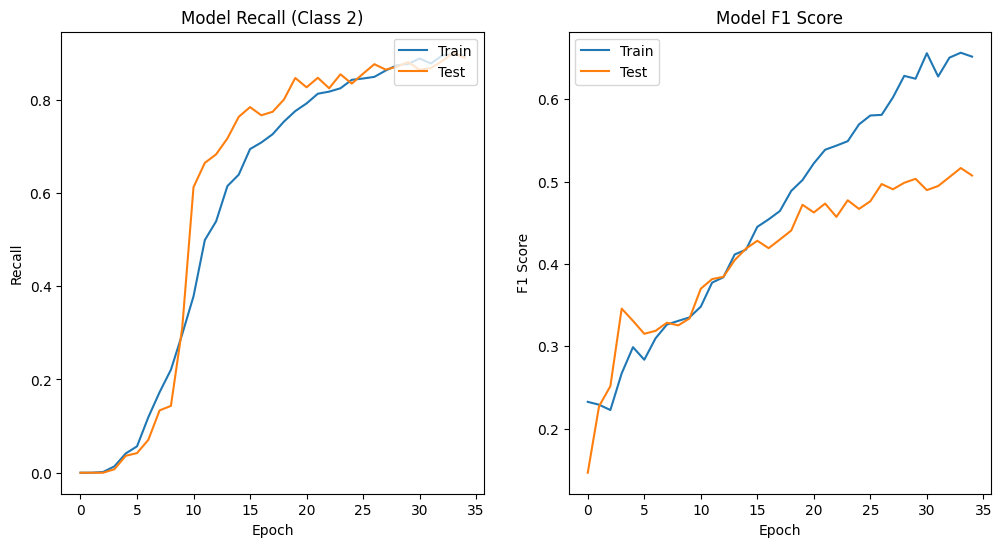

In [ ]:

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_17'])  # Assuming 'recall_2' is for the class you're interested in
plt.plot(history.history['val_recall_17'])
plt.title('Model Recall (Class 2)')  # Update title with relevant class name
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')




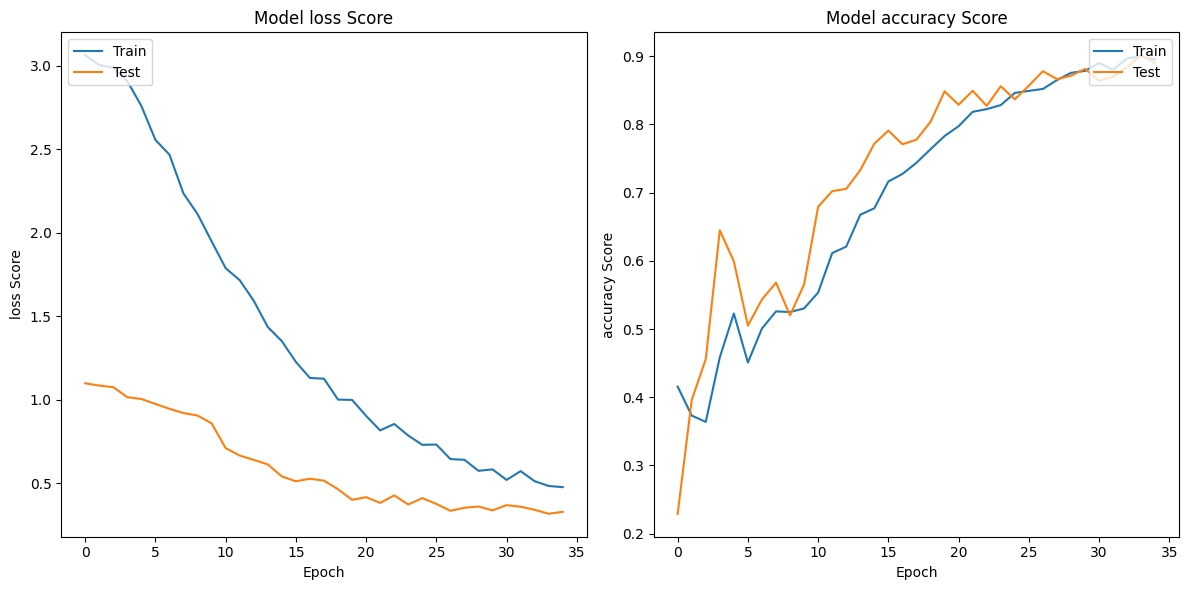

In [ ]:
# Plot training & validation loss score values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Score')
plt.ylabel('loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy score values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Score')
plt.ylabel('accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
prediction = insurance_norm_model_1.predict(smiles_test_comb)
prediction.shape

185/185 [==============================] - 1s 2ms/step


(5896, 3)

In [ ]:
pred = pd.DataFrame(prediction)
pred.rename(columns={0: -1, 1: 0, 2: 1}, inplace=True)
pred['task1'] = pred.idxmax(axis=1)
pred = pred['task1']
pred = pd.DataFrame(pred)
# Assuming pred is your DataFrame
pred.to_excel("pred_10.xlsx", index=True) # RENAME!!!!!!!!!!!

## TASK_11


In [ ]:
# unique and couunts
unique, counts = np.unique(y_11, return_counts=True) # rename!!!!!!!!!!!!!!!!!!!!
dict(zip(unique, counts))
# 9600 in total for training

{-1: 452, 0: 9109, 1: 39}

In [ ]:
minus_1 = 9109 / 452
zero = 9109/ 9109
plus_1 = 9109 / 39

In [ ]:
minus_1, zero, plus_1

(20.152654867256636, 1.0, 233.56410256410257)

In [ ]:
def convert_to_one_hot(df, column_name):
  df = pd.DataFrame(df.copy())  # Ensure we are working on a copy
  df_temp = pd.get_dummies(df[column_name])  # Create one-hot encoded columns, exclude first category
  df_temp = df_temp.astype(int)  # Convert True/False to 1/0
  df = pd.concat([df, df_temp], axis=1)  # Concatenate the original and encoded columns
  del df[column_name]  # Remove the original categorical column
  return df


In [ ]:
y_hot = convert_to_one_hot(y_11, 'task11')# rename!!!!!!!!!!!!!!!!!!!!!!
y_hot

-1  0  1
9182    0  1  0
11091   0  1  0
6428    0  1  0
288     0  1  0
2626    0  1  0
...    .. .. ..
11964   0  1  0
5191    0  1  0
5390    0  1  0
860     0  1  0
7270    0  1  0

[9600 rows x 3 columns]

In [ ]:
y_test_hot = convert_to_one_hot(y_test_11, 'task11') # rename!!!!!!!!!!!!!!!!!!!!!!
y_test_hot

-1  0  1
1935    0  1  0
6494    0  1  0
1720    0  1  0
9120    1  0  0
360     0  1  0
...    .. .. ..
1195    0  1  0
11877   0  1  0
5421    0  1  0
3855    0  1  0
4414    0  1  0

[2400 rows x 3 columns]

In [ ]:
# Define class weights
class_weight = {0: minus_1,  # weight for class -1
                1: zero,  # weight for class 0
                2: plus_1}   # weight for class +1

# Set random
tf.random.set_seed(42)

insurance_norm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu', input_shape=(1385,)),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(75, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),  # add dropout
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # use softmax for multi-class classification
])

# Compile the model
insurance_norm_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, use_ema=True, ema_momentum=0.9),
                             metrics=["accuracy", tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=3, average='macro')])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
)


# Fit the model with callbacks
history = insurance_norm_model_1.fit(X_train, y_hot, epochs=35, batch_size=32,
                                  validation_data=(X_test, y_test_hot),
                                  class_weight=class_weight,
                                  callbacks=[early_stopping, reduce_lr])

Epoch 1/35
300/300 [==============================] - 8s 14ms/step - loss: 3.2964 - accuracy: 0.8084 - recall_18: 0.5550 - f1_score: 0.3407 - val_loss: 0.5904 - val_accuracy: 0.9283 - val_recall_18: 0.6371 - val_f1_score: 0.3690 - lr: 0.0010
Epoch 2/35
300/300 [==============================] - 4s 12ms/step - loss: 2.6104 - accuracy: 0.8718 - recall_18: 0.6672 - f1_score: 0.4153 - val_loss: 0.4399 - val_accuracy: 0.9187 - val_recall_18: 0.7496 - val_f1_score: 0.4592 - lr: 0.0010
Epoch 3/35
300/300 [==============================] - 5s 15ms/step - loss: 2.3577 - accuracy: 0.8674 - recall_18: 0.7449 - f1_score: 0.4533 - val_loss: 0.3391 - val_accuracy: 0.8946 - val_recall_18: 0.8079 - val_f1_score: 0.5335 - lr: 0.0010
Epoch 4/35
300/300 [==============================] - 3s 11ms/step - loss: 2.1157 - accuracy: 0.8554 - recall_18: 0.7846 - f1_score: 0.5069 - val_loss: 0.3124 - val_accuracy: 0.8671 - val_recall_18: 0.8271 - val_f1_score: 0.5325 - lr: 0.0010
Epoch 5/35
300/300 [============

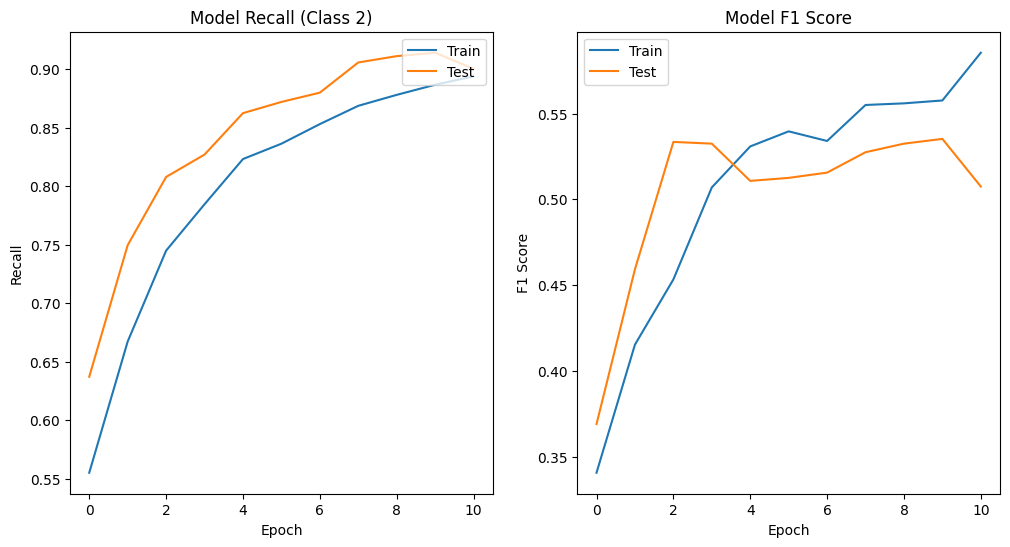

In [ ]:

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_18'])  # Assuming 'recall_2' is for the class you're interested in
plt.plot(history.history['val_recall_18'])
plt.title('Model Recall (Class 2)')  # Update title with relevant class name
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation F1 score values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')




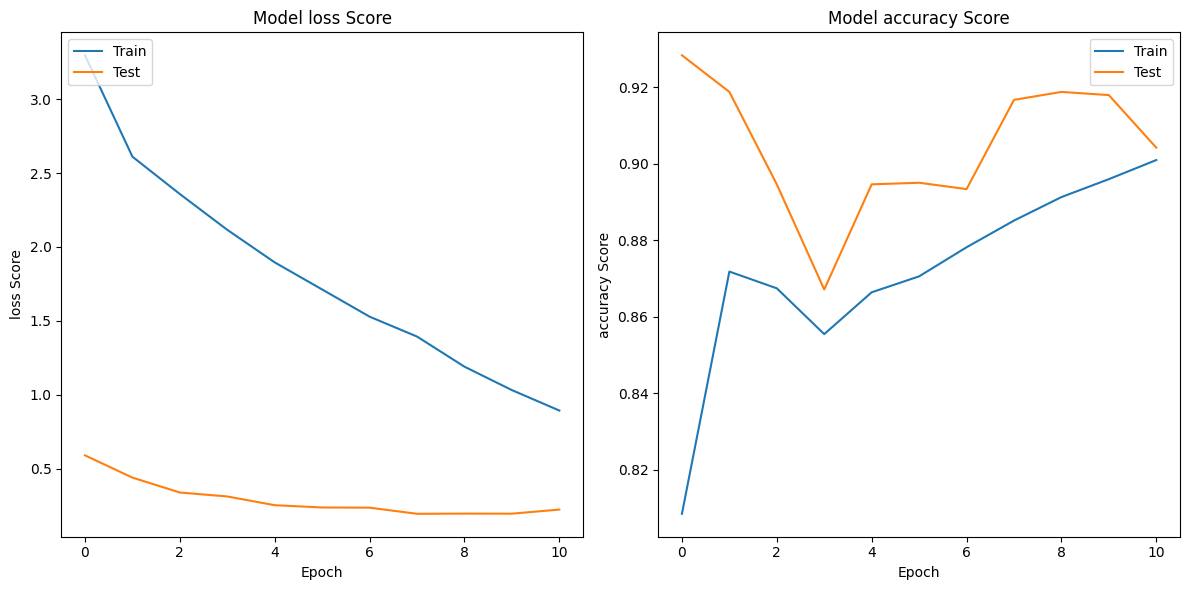

In [ ]:
# Plot training & validation loss score values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Score')
plt.ylabel('loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy score values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy Score')
plt.ylabel('accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
prediction = insurance_norm_model_1.predict(smiles_test_comb)
prediction.shape

185/185 [==============================] - 0s 2ms/step


(5896, 3)

In [ ]:
pred = pd.DataFrame(prediction)
pred.rename(columns={0: -1, 1: 0, 2: 1}, inplace=True)
pred['task1'] = pred.idxmax(axis=1)
pred = pred['task1']
pred = pd.DataFrame(pred)
# Assuming pred is your DataFrame
pred.to_excel("pred_11.xlsx", index=True) # RENAME!!!!!!!!!!!